# Visualization of Figures from the Article

This notebook reproduces all figures from the article "Effects of Extruder Dynamics and Noise on Simulated Chromatin Contact Probability Curves".

## Overview

This notebook demonstrates how to:
1. Generate CVD (Contact vs Distance) CSV files from .mcool files
2. Load pre-generated CVD CSV files
3. Create combined figures (P(s) + Metrics) like Figure 1 (1A + 1B together)
4. Visualize loop distributions
5. Compare different extruder lifetimes
6. Generate supplementary figures

## Workflow

1. **Generate CSV files**: Run the "Generate CVD CSV files" section to create CSV files from all .mcool files
2. **Load and plot**: Use the loaded CSV files to create publication-ready figures


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Import visualization functions
from draw_and_plot import (
    data_loader,
    calculate_contact_vs_distance,
    plot_combined_ps_and_metrics,
    plot_combined_ps_and_loops,
    plot_three_lifetime_comparisons
)
from spiral_metrics import compute_C_s, generate_cylindrical_spiral
import polychrom.hdf5_format as hdf5

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11
})

# Ensure SVG text is preserved as text (for publication figures)
mpl.rcParams['svg.fonttype'] = 'none'

# Base directories
PROJECT_ROOT = Path("..").resolve()
COOLMAPS_DIR = PROJECT_ROOT / "coolmaps" / "draw_ps_article" / "coolmaps"
EXPERIMENTS_DIR = PROJECT_ROOT / "exp_data"
ARTICLE_CODE_DIR = Path.cwd()
DATA_FOR_FIGS_DIR = ARTICLE_CODE_DIR / "data_for_figs"
FIGURES_DIR = ARTICLE_CODE_DIR / "figures"

# Create directories if they don't exist
DATA_FOR_FIGS_DIR.mkdir(exist_ok=True)
FIGURES_DIR.mkdir(exist_ok=True)

print("Libraries imported successfully!")
print(f"Data directory: {DATA_FOR_FIGS_DIR}")
print(f"Figures directory: {FIGURES_DIR}")


Libraries imported successfully!
Data directory: /storage2/vvkonstantinov/Re_model/article_code/data_for_figs
Figures directory: /storage2/vvkonstantinov/Re_model/article_code/figures


## Step 1: Generate CVD CSV files from .mcool files

This section generates CSV files from all experimental and simulated .mcool files.
Run this section first to create the data files needed for plotting.

**Note**: By default, `view_df` is automatically built from cooler chromsizes.
If you need to specify a custom region, you can pass a view_df:
```python
custom_view_df = pd.DataFrame({
    'chrom': ['chr0'],
    'start': [0],
    'end': [40000000],
    'name': ['chr0']
})
generate_csv_from_mcool(mcool_path, csv_name, view_df=custom_view_df, smooth=True, sigma=0.12)
```


In [ ]:
# Default target resolution
TARGET_RESOLUTION = 1000  # bp

# Dictionary to store generated CSV file paths
generated_csvs = {}

def generate_csv_from_mcool(mcool_path, csv_name, 
                            view_df=None, 
                            target_resolution=TARGET_RESOLUTION,
                            smooth=True, 
                            sigma=0.12 # This parameter has no common with sigma-noise implemented to contact maps
                            ):
    """
    Generate CSV file from .mcool file using calculate_contact_vs_distance.
    
    Args:
        mcool_path: Path to .mcool file
        csv_name: Name for the output CSV file (without .csv extension)
        view_df: Optional DataFrame with genomic regions (chrom, start, end, name).
                 If None (default), view_df will be automatically built from cooler chromsizes.
        target_resolution: Target resolution in bp (default: 1000)
        smooth: Whether to apply smoothing to expected contact probabilities (default: True)
        sigma: Smoothing parameter in log10 distance units (default: 0.1)
        
    Returns:
        Path to the generated CSV file, or None if failed
    """
    mcool_path = Path(mcool_path)
    if not mcool_path.exists():
        print(f"   ✗ File not found: {mcool_path}")
        return None
    
    try:
        _, _, _, res = data_loader(mcool_path, target_resolution)
        cvd = calculate_contact_vs_distance(
            view_df=view_df,  # None means auto-build from cooler
            target_resolution=res,
            sample_id=str(mcool_path),
            smooth=smooth,
            sigma=sigma
        )
        csv_path = DATA_FOR_FIGS_DIR / f"{csv_name}.csv"
        cvd.to_csv(csv_path, index=False)
        generated_csvs[csv_name] = csv_path
        print(f"   ✓ {csv_name}.csv")
        return csv_path
    except Exception as e:
        print(f"   ✗ Error processing {mcool_path.name}: {e}")
        import traceback
        traceback.print_exc()
        return None

print("Generating CSV files from .mcool files needed for figures...")
print("=" * 60)

# ===== FIGURE 1: Step vs DPD Potentials =====
print("\n[Figure 1] Step vs DPD Potentials with Experimental Data")
print("-" * 60)

# 1. Experimental data (DT40) - used in all figures
print("\n1. Experimental data (DT40):")
exp_file = EXPERIMENTS_DIR / "GSM8171175_SMC3-CAPH2-AID-30min-S3-R2-SpnA_galGal7b.galGal7b.mapq_30.1000.mcool"
generate_csv_from_mcool(exp_file, "DT40_experimental")

# 2. Step potential - aggregated data (sigma=0, same as single cells, for Figure 1)
print("\n2. Step potential (static extruders, aggregated, sigma=0 for Figure 1):")
generate_csv_from_mcool(
    COOLMAPS_DIR / "cond1_gol_p_plen3_sigma0.mcool",
    "cond1_gol_p_plen3_sigma0"
)

# 2b. Step potential - aggregated data (sigma=200, for other figures)
print("\n2b. Step potential (static extruders, aggregated, sigma=200 for other figures):")
generate_csv_from_mcool(
    COOLMAPS_DIR / "cond1_gol_p_plen3_sigma200.mcool",
    "cond1_gol_p_plen3_sigma200"
)

# 2a. Step potential - single cells (transparent lines for Figure 1)
print("\n2a. Step potential (single cells, transparent lines):")
SINGLE_CELLS_DIR = PROJECT_ROOT / "coolmaps" / "draw_ps_article" / "tmp" / "cells_cond1_gol_p_plen3"
for cell_num in range(5):  # cell_0 to cell_4
    cell_mcool = SINGLE_CELLS_DIR / f"cell_{cell_num}" / "single_map_sigma0.mcool"
    if cell_mcool.exists():
        generate_csv_from_mcool(
            cell_mcool,
            f"step_single_cell_{cell_num}"
        )
    else:
        print(f"   ⚠ Single cell file not found: {cell_mcool}")

# 3. DPD potential - aggregated data (sigma=0)
print("\n3. DPD potential (static extruders, aggregated):")
generate_csv_from_mcool(
    COOLMAPS_DIR / "cond1_gol_p_plen0_dpdforce_sigma0.mcool",
    "cond1_gol_p_plen0_dpdforce_sigma0"
)

# 3a. DPD potential - single cells (transparent lines for Figure 1)
print("\n3a. DPD potential (single cells, transparent lines):")
SINGLE_CELLS_DPD_DIR = PROJECT_ROOT / "coolmaps" / "draw_ps_article" / "tmp" / "cells_cond1_gol_p_plen0_dpdforce"
for cell_num in range(5):  # cell_0 to cell_4
    cell_mcool = SINGLE_CELLS_DPD_DIR / f"cell_{cell_num}" / "single_map_sigma0.mcool"
    if cell_mcool.exists():
        generate_csv_from_mcool(
            cell_mcool,
            f"dpd_single_cell_{cell_num}"
        )
    else:
        print(f"   ⚠ Single cell file not found: {cell_mcool}")

# ===== APPENDIX FIGURES: Effect of sigma noise =====
print("\n[Appendix Figures A1 & A2] Effect of sigma noise on Step and DPD potentials")
print("-" * 60)

# A1 & A2: Step and DPD potentials with different sigma values
print("\n6. Step potential with different sigma values (for A1 Fig):")
step_sigma_files = {
    'cond1_gol_p_plen3_sigma50': COOLMAPS_DIR / "cond1_gol_p_plen3_sigma50.mcool",
    'cond1_gol_p_plen3_sigma100': COOLMAPS_DIR / "cond1_gol_p_plen3_sigma100.mcool",
    'cond1_gol_p_plen3_sigma200': COOLMAPS_DIR / "cond1_gol_p_plen3_sigma200.mcool",
    'cond1_gol_p_plen3_sigma400': COOLMAPS_DIR / "cond1_gol_p_plen3_sigma400.mcool",
}
for csv_name, mcool_path in step_sigma_files.items():
    if not Path(csv_name + '.csv').exists() or csv_name not in generated_csvs:
        generate_csv_from_mcool(mcool_path, csv_name)

print("\n7. DPD potential with different sigma values (for A2 Fig):")
dpd_sigma_files = {
    'cond1_gol_p_plen0_dpdforce_sigma50': COOLMAPS_DIR / "cond1_gol_p_plen0_dpdforce_sigma50.mcool",
    'cond1_gol_p_plen0_dpdforce_sigma100': COOLMAPS_DIR / "cond1_gol_p_plen0_dpdforce_sigma100.mcool",
    'cond1_gol_p_plen0_dpdforce_sigma200': COOLMAPS_DIR / "cond1_gol_p_plen0_dpdforce_sigma200.mcool",
    'cond1_gol_p_plen0_dpdforce_sigma400': COOLMAPS_DIR / "cond1_gol_p_plen0_dpdforce_sigma400.mcool",
}
for csv_name, mcool_path in dpd_sigma_files.items():
    if not Path(csv_name + '.csv').exists() or csv_name not in generated_csvs:
        generate_csv_from_mcool(mcool_path, csv_name)

# ===== FIGURE 2: Dynamic Extruders with Different Lifetimes =====
print("\n[Figure 2] Dynamic Extruders with Different Lifetimes")
print("-" * 60)

# Static extruder (already generated above as cond1_gol_p_plen3_sigma200)
# Dynamic extruders with different lifetimes
print("\n4. Dynamic extruders (lifetimes: 17, 68, 136 sec):")
dynamic_files = {
    'cond1_gol_p_plen3_dynamic_lt_1div6_sigma200': COOLMAPS_DIR / "cond1_gol_p_plen3_dynamic_lt_1div6_sigma200.mcool",  # 17 sec
    'cond1_gol_p_plen3_dynamic_lt_4div6_sigma200': COOLMAPS_DIR / "cond1_gol_p_plen3_dynamic_lt_4div6_sigma200.mcool",  # 68 sec
    'cond1_gol_p_plen3_dynamic_lt_8div6_sigma200': COOLMAPS_DIR / "cond1_gol_p_plen3_dynamic_lt_8div6_sigma200.mcool",  # 136 sec
}
for csv_name, mcool_path in dynamic_files.items():
    generate_csv_from_mcool(mcool_path, csv_name)

# ===== FIGURE 3: Dynamic Extruders with Spatial Exclusion (Unnested) =====
print("\n[Figure 3] Dynamic Extruders with Spatial Exclusion (Unnested)")
print("-" * 60)

# Dynamic unnested extruders
print("\n5. Dynamic unnested extruders (lifetimes: 17, 68, 136 sec):")
unnested_files = {
    'cond1_gol_p_plen3_dynamic_lt_1div6_unnested_sigma200': COOLMAPS_DIR / "cond1_gol_p_plen3_dynamic_lt_1div6_unnested_sigma200.mcool",
    'cond1_gol_p_plen3_dynamic_lt_4div6_unnested_sigma200': COOLMAPS_DIR / "cond1_gol_p_plen3_dynamic_lt_4div6_unnested_sigma200.mcool",
    'cond1_gol_p_plen3_dynamic_lt_8div6_unnested_sigma200': COOLMAPS_DIR / "cond1_gol_p_plen3_dynamic_lt_8div6_unnested_sigma200.mcool",
}
for csv_name, mcool_path in unnested_files.items():
    generate_csv_from_mcool(mcool_path, csv_name)

# Save metadata
metadata = {
    "target_resolution": TARGET_RESOLUTION,
    "default_parameters": {
        "smooth": True,
        "sigma": 0.12,
        "view_df": "auto (built from cooler chromsizes)"
    },
    "files": {name: str(path) for name, path in generated_csvs.items()}
}

metadata_path = DATA_FOR_FIGS_DIR / "metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print("\n" + "=" * 60)
print(f"✓ Generated {len(generated_csvs)} CSV files")
print(f"✓ Metadata saved to: {metadata_path}")
print("=" * 60)


## Step 2: Create Figures

### Figure 1: Combined P(s) and Metrics (1A + 1B)

This figure combines:
- Left side: P(s) curves and derivative (1A)
- Right side: Metrics sensitivity to normalization point (1B)

#### Step vs DPD Potentials with Experimental Data



[Figure 1] Step and DPD Potentials with Experimental Data (Combined)
Loading datasets...
Creating combined figure (P(s) + Metrics) with Step and DPD together...
Analyzing metrics across 50 normalization points...
[50/50] 2000000.0000000002 bp


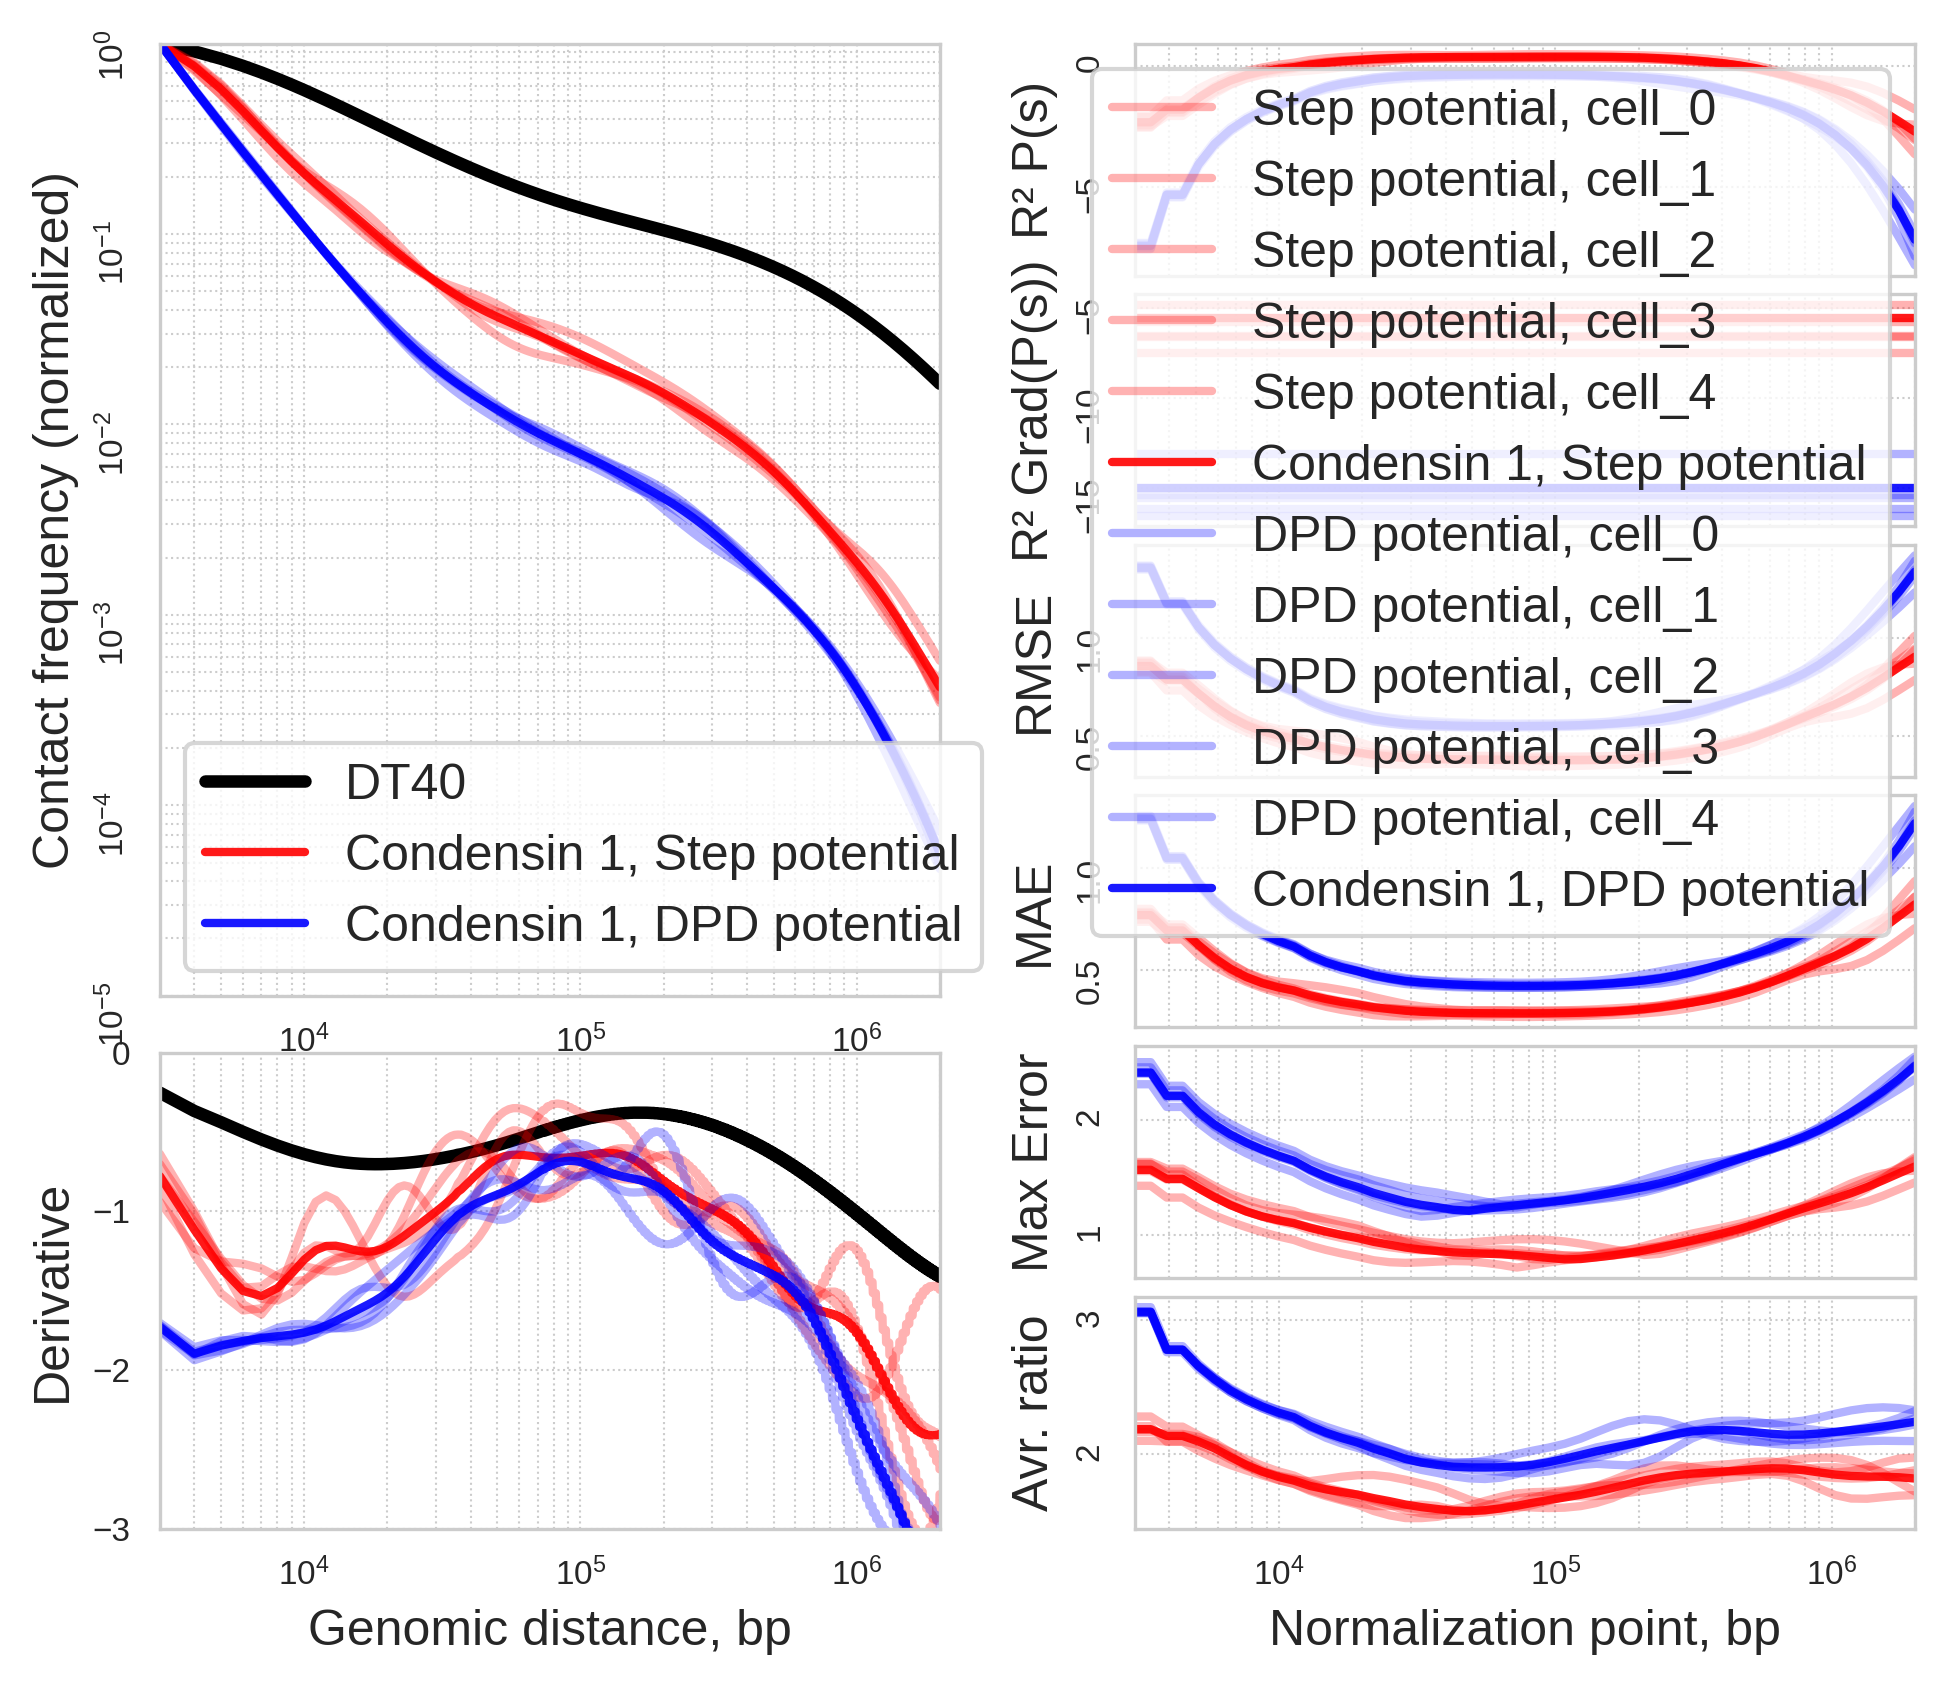

✓ Figure 1 (Step + DPD combined) saved as /storage2/vvkonstantinov/Re_model/article_code/figures/Combined_Ps_and_Metrics_Step_and_DPD.svg


In [2]:
# Define datasets for Figure 1
# Figure 1 shows Step and DPD potentials on ONE figure for visual comparison:
# - Experimental data (DT40) - black solid line
# - Single cells (transparent lines) - raw model single cells
# - Aggregated data (solid lines) - aggregated raw model data
# Step potential (red line) and DPD potential (blue line) on the same plot

# Combined dataset with Step and DPD potentials together
fig1_datasets = {
    'DT40': {
        'csv_path': DATA_FOR_FIGS_DIR / 'DT40_experimental.csv',
        'color': 'black',
        'style': 'solid',
        'alpha': 1.0
    }
}

# Add Step potential single cells (transparent lines) - cell_0 to cell_4
# These are not shown in legend for clarity
for cell_num in range(5):
    fig1_datasets[f'Step potential, cell_{cell_num}'] = {
        'csv_path': DATA_FOR_FIGS_DIR / f'step_single_cell_{cell_num}.csv',
        'color': 'red',  # Red color for Step potential
        'style': 'solid',
        'alpha': 0.3,  # Transparent lines for single cells
        'show_in_legend': False  # Hide from legend for clarity
    }

# Add Step potential aggregated data (solid line, sigma=0)
fig1_datasets['Condensin 1, Step potential'] = {
    'csv_path': DATA_FOR_FIGS_DIR / 'cond1_gol_p_plen3_sigma0.csv',  # Aggregated data with sigma=0
    'color': 'red',  # Red line as in article
    'style': 'solid',
    'alpha': 0.9  # Solid line for aggregated data
}

# Add DPD potential single cells (transparent lines) - cell_0 to cell_4
# These are not shown in legend for clarity
for cell_num in range(5):
    fig1_datasets[f'DPD potential, cell_{cell_num}'] = {
        'csv_path': DATA_FOR_FIGS_DIR / f'dpd_single_cell_{cell_num}.csv',
        'color': 'blue',  # Blue color for DPD potential
        'style': 'solid',
        'alpha': 0.3,  # Transparent lines for single cells
        'show_in_legend': False  # Hide from legend for clarity
    }

# Add DPD potential aggregated data (solid line)
fig1_datasets['Condensin 1, DPD potential'] = {
    'csv_path': DATA_FOR_FIGS_DIR / 'cond1_gol_p_plen0_dpdforce_sigma0.csv',  # Aggregated data
    'color': 'blue',  # Blue line as in article
    'style': 'solid',
    'alpha': 0.9  # Solid line for aggregated data
}

# Plotting parameters (matching original notebook)
PLOT_KW_FIG1 = dict(
    reference_names=['DT40'],
    x_limits=(3e3, 2e6),
    y1_limits=(1e-5, 1e0),
    y2_limits=(-3, 0.),
    min_distance=3000,
    max_distance=2000000,
    alignment_min_distance=3000,
    alignment_max_distance=2000000,
    max_points=50,
    normalize=True,
    alignment_s_bp=3000,
    figsize=(6.5, 5.5),  # As in original notebook
    dpi=300
)

# Create Figure 1 - Combined Step and DPD potentials on one figure
print("\n[Figure 1] Step and DPD Potentials with Experimental Data (Combined)")
print("Loading datasets...")

if len(fig1_datasets) >= 3:  # At least DT40 + Step aggregated + DPD aggregated
    print("Creating combined figure (P(s) + Metrics) with Step and DPD together...")
    fig = plot_combined_ps_and_metrics(fig1_datasets, **PLOT_KW_FIG1)
    fig_path = FIGURES_DIR / 'Combined_Ps_and_Metrics_Step_and_DPD.svg'
    plt.savefig(fig_path, format='svg', bbox_inches='tight')
    plt.show()
    print(f"✓ Figure 1 (Step + DPD combined) saved as {fig_path}")
else:
    print("✗ Need at least 3 datasets for Figure 1 (DT40 + Step aggregated + DPD aggregated).")
    print(f"   Loaded: {list(fig1_datasets.keys())}")


### Figure 2: Dynamic Extruders with Different Lifetimes

This figure shows:
- P(s) curves for static and dynamic extruders with different lifetimes (17, 68, 136 sec)
- Loop size distributions for each condition



[Figure 2] Dynamic Extruders with Different Lifetimes
Loading datasets...

Creating Figure 2 with loop distributions...


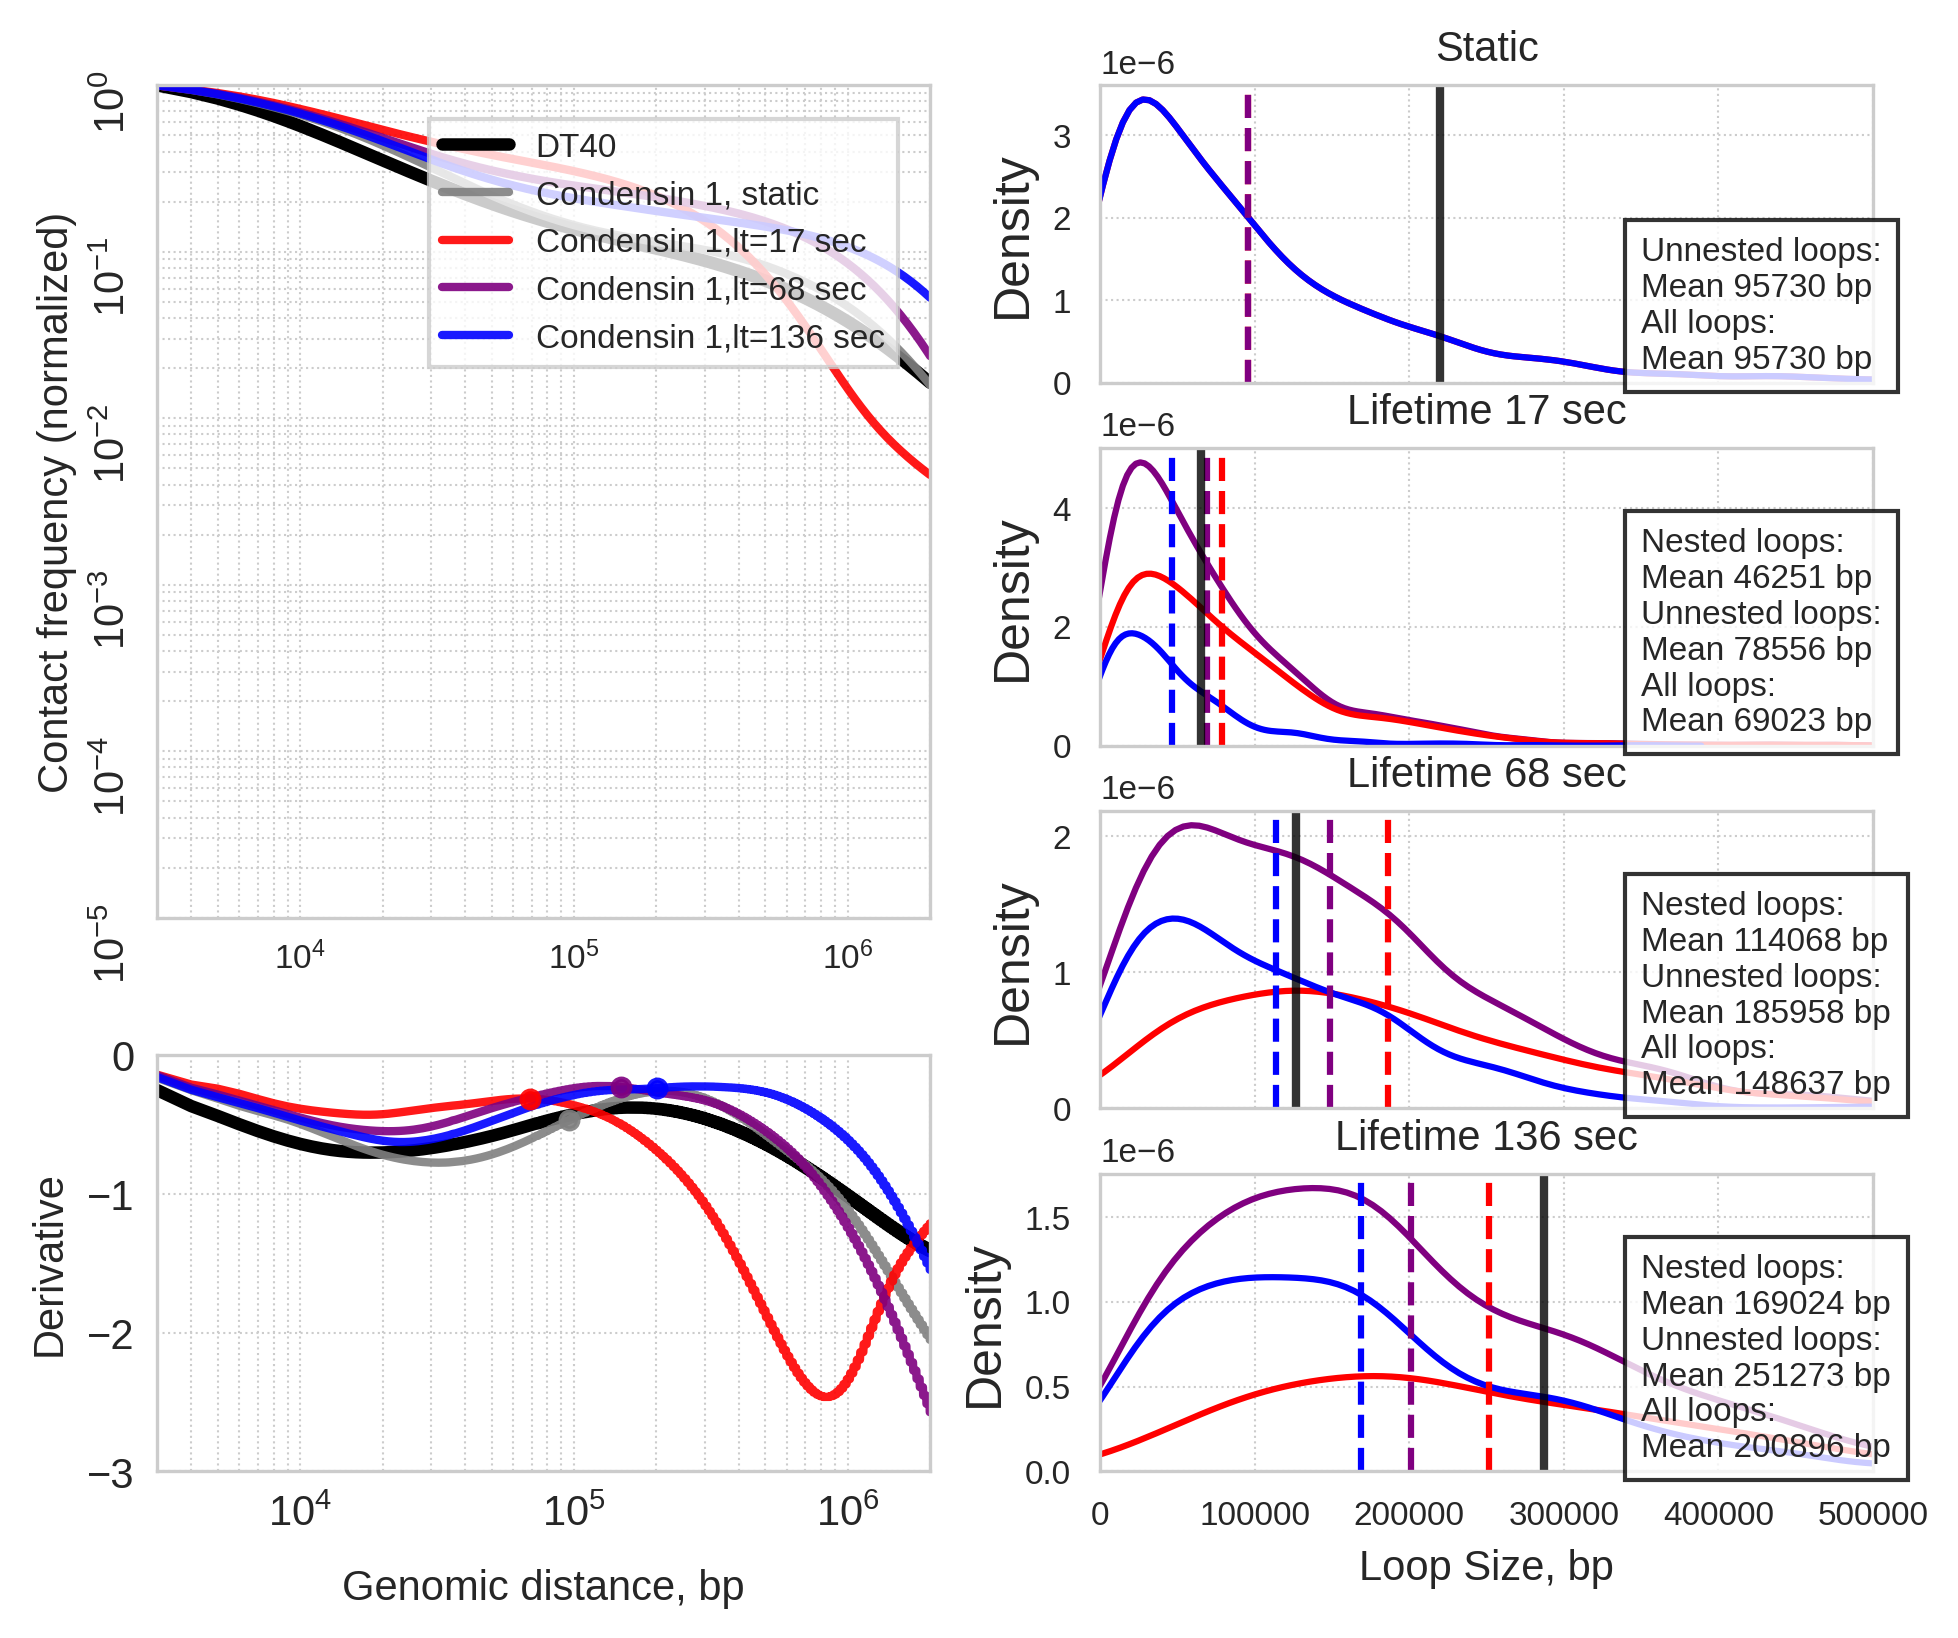

✓ Figure 2 (P(s) + Loops) saved as /storage2/vvkonstantinov/Re_model/article_code/figures/Combined_Ps_and_Loops_Static_and_Three_Lifetimes.svg


In [3]:
# Define datasets for Figure 2
# Based on original notebook: Combined_Ps_and_Loops_Static_and_Three_Lifetimes.svg
# Note: Names use 'lt=' format to match plot_combined_ps_and_loops expectations
# Colors: DT40=black, Static=grey, others=gradient (red, purple, blue)
dynamic_samples = {
    'Condensin 1, static': 'cond1_gol_p_plen3_sigma200',
    'Condensin 1,lt=17 sec': 'cond1_gol_p_plen3_dynamic_lt_1div6_sigma200',
    'Condensin 1,lt=68 sec': 'cond1_gol_p_plen3_dynamic_lt_4div6_sigma200',
    'Condensin 1,lt=136 sec': 'cond1_gol_p_plen3_dynamic_lt_8div6_sigma200',
}
# Gradient palette for dynamic lifetimes only (excluding static)
dynamic_palette = sns.color_palette('blend:red,purple,blue', n_colors=3).as_hex()

fig2_datasets = {
    'DT40': {
        'csv_path': DATA_FOR_FIGS_DIR / 'DT40_experimental.csv',
        'color': 'black',  # DT40: black line
        'style': 'solid',
        'alpha': 1.0
    }
}

# Add static and dynamic samples with correct colors
lifetime_idx = 0
for name, csv_name in dynamic_samples.items():
    if 'static' in name:
        # Static: grey line
        fig2_datasets[name] = {
            'csv_path': DATA_FOR_FIGS_DIR / f'{csv_name}.csv',
            'color': 'grey',
            'style': 'solid',
            'alpha': 0.9
        }
    else:
        # Dynamic lifetimes: gradient colors (red, purple, blue)
        fig2_datasets[name] = {
            'csv_path': DATA_FOR_FIGS_DIR / f'{csv_name}.csv',
            'color': dynamic_palette[lifetime_idx],
            'style': 'solid',
            'alpha': 0.9
        }
        lifetime_idx += 1

# Build data_dict
print("\n[Figure 2] Dynamic Extruders with Different Lifetimes")
print("Loading datasets...")

# Plotting parameters (matching original notebook)
PLOT_KW_FIG2 = dict(
    reference_names=['DT40'],
    x_limits=(3e3, 2e6),
    y1_limits=(1e-3, 1e0),
    y2_limits=(-3, 0.),
    min_distance=3000,
    max_distance=2000000,
    alignment_min_distance=3000,
    alignment_max_distance=2000000,
    max_points=50,
    normalize=True,
    alignment_s_bp=3000,
    figsize=(6.5, 5.5),  # As in original notebook
    dpi=300
)

# Create Figure 2 with P(s) + Loop distributions (if loop data is available)
# Note: This requires loop statistics data in the loops_base_dir
# The figure shows:
# - Left: P(s) curves and derivative with markers (big dots) indicating mean loop sizes
# - Right: Loop size distributions for each lifetime configuration

loops_base_dir = PROJECT_ROOT / "coolmaps" / "draw_ps_article"
if loops_base_dir.exists():
    print("\nCreating Figure 2 with loop distributions...")
    plt.close('all')
    try:
        fig_loops = plot_combined_ps_and_loops(
            fig2_datasets,
            x_limits=(3e3, 2e6),
            y1_limits=(1e-5, 1e0),
            y2_limits=(-3, 0.),
            normalize=True,
            alignment_s_bp=3000,
            loops_base_dir=str(loops_base_dir),
            bead_size=200,
            max_distance_beads=2500,
            figsize=(6.5, 5.5),
            dpi=300
        )
        fig_path_loops = FIGURES_DIR / 'Combined_Ps_and_Loops_Static_and_Three_Lifetimes.svg'
        plt.savefig(fig_path_loops, format='svg', bbox_inches='tight')
        plt.show()
        print(f"✓ Figure 2 (P(s) + Loops) saved as {fig_path_loops}")
    except Exception as e:
        print(f"⚠ Could not create loop distributions figure: {e}")
        import traceback
        traceback.print_exc()
else:
    print(f"⚠ Loops base directory not found: {loops_base_dir}")
    print("   Skipping loop distributions figure")


### Figure 3: Three Lifetime Comparisons Side-by-Side

This figure shows three plots side-by-side, each comparing:
- DT40 experimental data
- Static extruders
- Dynamic extruders with specific lifetime
- Dynamic unnested extruders with same lifetime



[Figure 3] Three Lifetime Comparisons
Loading datasets...
Creating three lifetime comparisons figure...


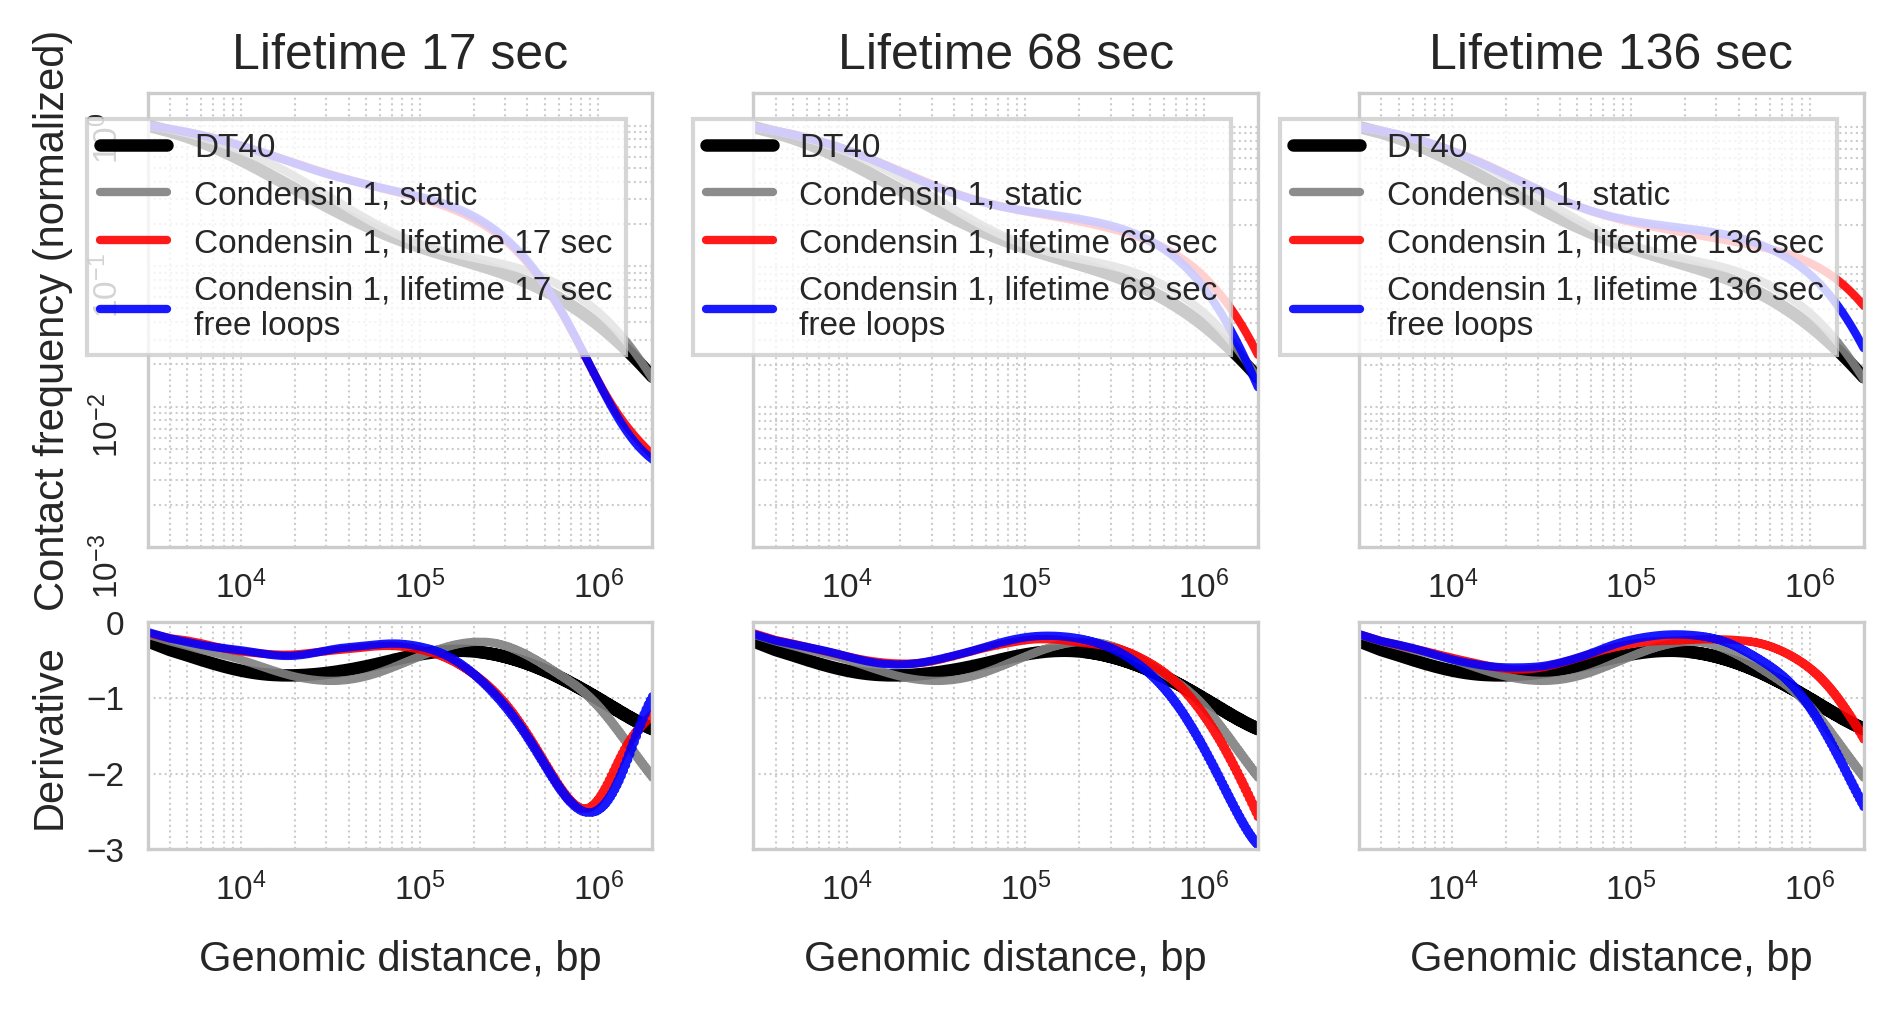

✓ Figure 4 saved as /storage2/vvkonstantinov/Re_model/article_code/figures/Three_Lifetime_Comparisons.svg


In [4]:
# Define datasets for Figure 4 (Three Lifetime Comparisons)
# Based on original notebook: Three_Lifetime_Comparisons.svg
# This figure needs: DT40, static, and for each lifetime: dynamic and unnested versions
fig4_datasets = {
    'DT40': {
        'csv_path': DATA_FOR_FIGS_DIR / 'DT40_experimental.csv',
        'color': 'black',
        'style': 'solid',
        'alpha': 1.0
    },
    'Condensin 1, static': {
        'csv_path': DATA_FOR_FIGS_DIR / 'cond1_gol_p_plen3_sigma200.csv',
        'color': 'grey',
        'style': 'solid',
        'alpha': 0.9
    },
    'Condensin 1, lifetime 17 sec': {
        'csv_path': DATA_FOR_FIGS_DIR / 'cond1_gol_p_plen3_dynamic_lt_1div6_sigma200.csv',
        'color': 'red',
        'style': 'solid',
        'alpha': 0.9
    },
    'Condensin 1, lifetime 17 sec, free loops': {
        'csv_path': DATA_FOR_FIGS_DIR / 'cond1_gol_p_plen3_dynamic_lt_1div6_unnested_sigma200.csv',
        'color': 'blue',
        'style': 'solid',
        'alpha': 0.9
    },
    'Condensin 1, lifetime 68 sec': {
        'csv_path': DATA_FOR_FIGS_DIR / 'cond1_gol_p_plen3_dynamic_lt_4div6_sigma200.csv',
        'color': 'red',
        'style': 'solid',
        'alpha': 0.9
    },
    'Condensin 1, lifetime 68 sec, free loops': {
        'csv_path': DATA_FOR_FIGS_DIR / 'cond1_gol_p_plen3_dynamic_lt_4div6_unnested_sigma200.csv',
        'color': 'blue',
        'style': 'solid',
        'alpha': 0.9
    },
    'Condensin 1, lifetime 136 sec': {
        'csv_path': DATA_FOR_FIGS_DIR / 'cond1_gol_p_plen3_dynamic_lt_8div6_sigma200.csv',
        'color': 'red',
        'style': 'solid',
        'alpha': 0.9
    },
    'Condensin 1, lifetime 136 sec, free loops': {
        'csv_path': DATA_FOR_FIGS_DIR / 'cond1_gol_p_plen3_dynamic_lt_8div6_unnested_sigma200.csv',
        'color': 'blue',
        'style': 'solid',
        'alpha': 0.9
    }
}

# Build data_dict
print("\n[Figure 3] Three Lifetime Comparisons")
print("Loading datasets...")

if len(fig4_datasets) >= 4:
    print("Creating three lifetime comparisons figure...")
    fig = plot_three_lifetime_comparisons(
        fig4_datasets,
        x_limits=(3e3, 2e6),
        y1_limits=(1e-3, 0),
        y2_limits=(-3, 0.),
        normalize=True,
        alignment_s_bp=3000,
        figsize=(6.5, 3.0),  # As in original notebook
        dpi=300
    )
    fig_path = FIGURES_DIR / 'Three_Lifetime_Comparisons.svg'
    plt.savefig(fig_path, format='svg', bbox_inches='tight')
    plt.show()
    print(f"✓ Figure 4 saved as {fig_path}")
else:
    print("✗ Need at least 4 datasets for Figure 4.")
    print(f"   Loaded: {list(fig4_datasets.keys())}")


## Supplementary Figures

### S1 Fig. Effect of extruder lifetime on contact probability P(s) profiles with different metrics

**A)** P(s) curves in range 3 kbp - 2 Mbp for experimental data for chicken cells line DT40 (black line), aggregated model data. Static (grey line) and dynamic extruders on three lifetimes with base physical parameters (red, blue, purple lines). Big dots at derivative graphs correspond to mean loop size.

**B)** Results of comparing segments experiment DT40 P(s) vs model data for dynamic extruders on three lifetimes with shifting normalisation point on different metrics. The normalization point shifts within the range of 3 kbp to 2 Mbp. The comparable segment of the plot is 3 kbp-2 Mbp. Sigma-noise is 200 nm.

### S2 Fig. Effect of extruder lifetime free loops on contact probability P(s) profiles with different metrics

**A)** P(s) curves in range 3 kbp - 2 Mbp for experimental data for chicken cells line DT40 (black line), aggregated model data. Static (grey line) and dynamic extruders, which are unable to load at existing loops, on three lifetimes with base physical parameters (red, blue, purple lines). Big dots at derivative graphs correspond to mean loop size.

**B)** Results of comparing segments experiment DT40 P(s) vs model data on different metrics. The normalization point shifts within the range of 3 kbp to 2 Mbp. The comparable segment of the plot is 3 kbp-2 Mbp. Sigma-noise is 200 nm.

### S3 Fig. Effect of extruder lifetime free loops on contact probability P(s) profiles with loop size distributions

**A)** P(s) curves in range 3 kbp - 2 Mbp for experimental data for chicken cells line DT40 (black line), aggregated model data. Static (grey line) and dynamic extruders, which are unable to load at existing loops, on three lifetimes for Step potential parameters (red, blue, purple lines). Big dots at derivative graphs correspond to mean loop size.

**B)** Loop sizes distribution for different lifetimes. All graphs normalised on area under all-loops graph. Purple line - all extruders. 1) Static extruders, 2) Dynamic extruders lt = 17 sec, 3) Dynamic extruders lt - 68 sec, 4) Dynamic extruders 136 sec.



[S1 Fig] Effect of extruder lifetime on contact probability P(s) profiles
Loading datasets...
Creating S1 figure (P(s) + Metrics)...
Analyzing metrics across 50 normalization points...
[50/50] 2000000.0000000002 bp


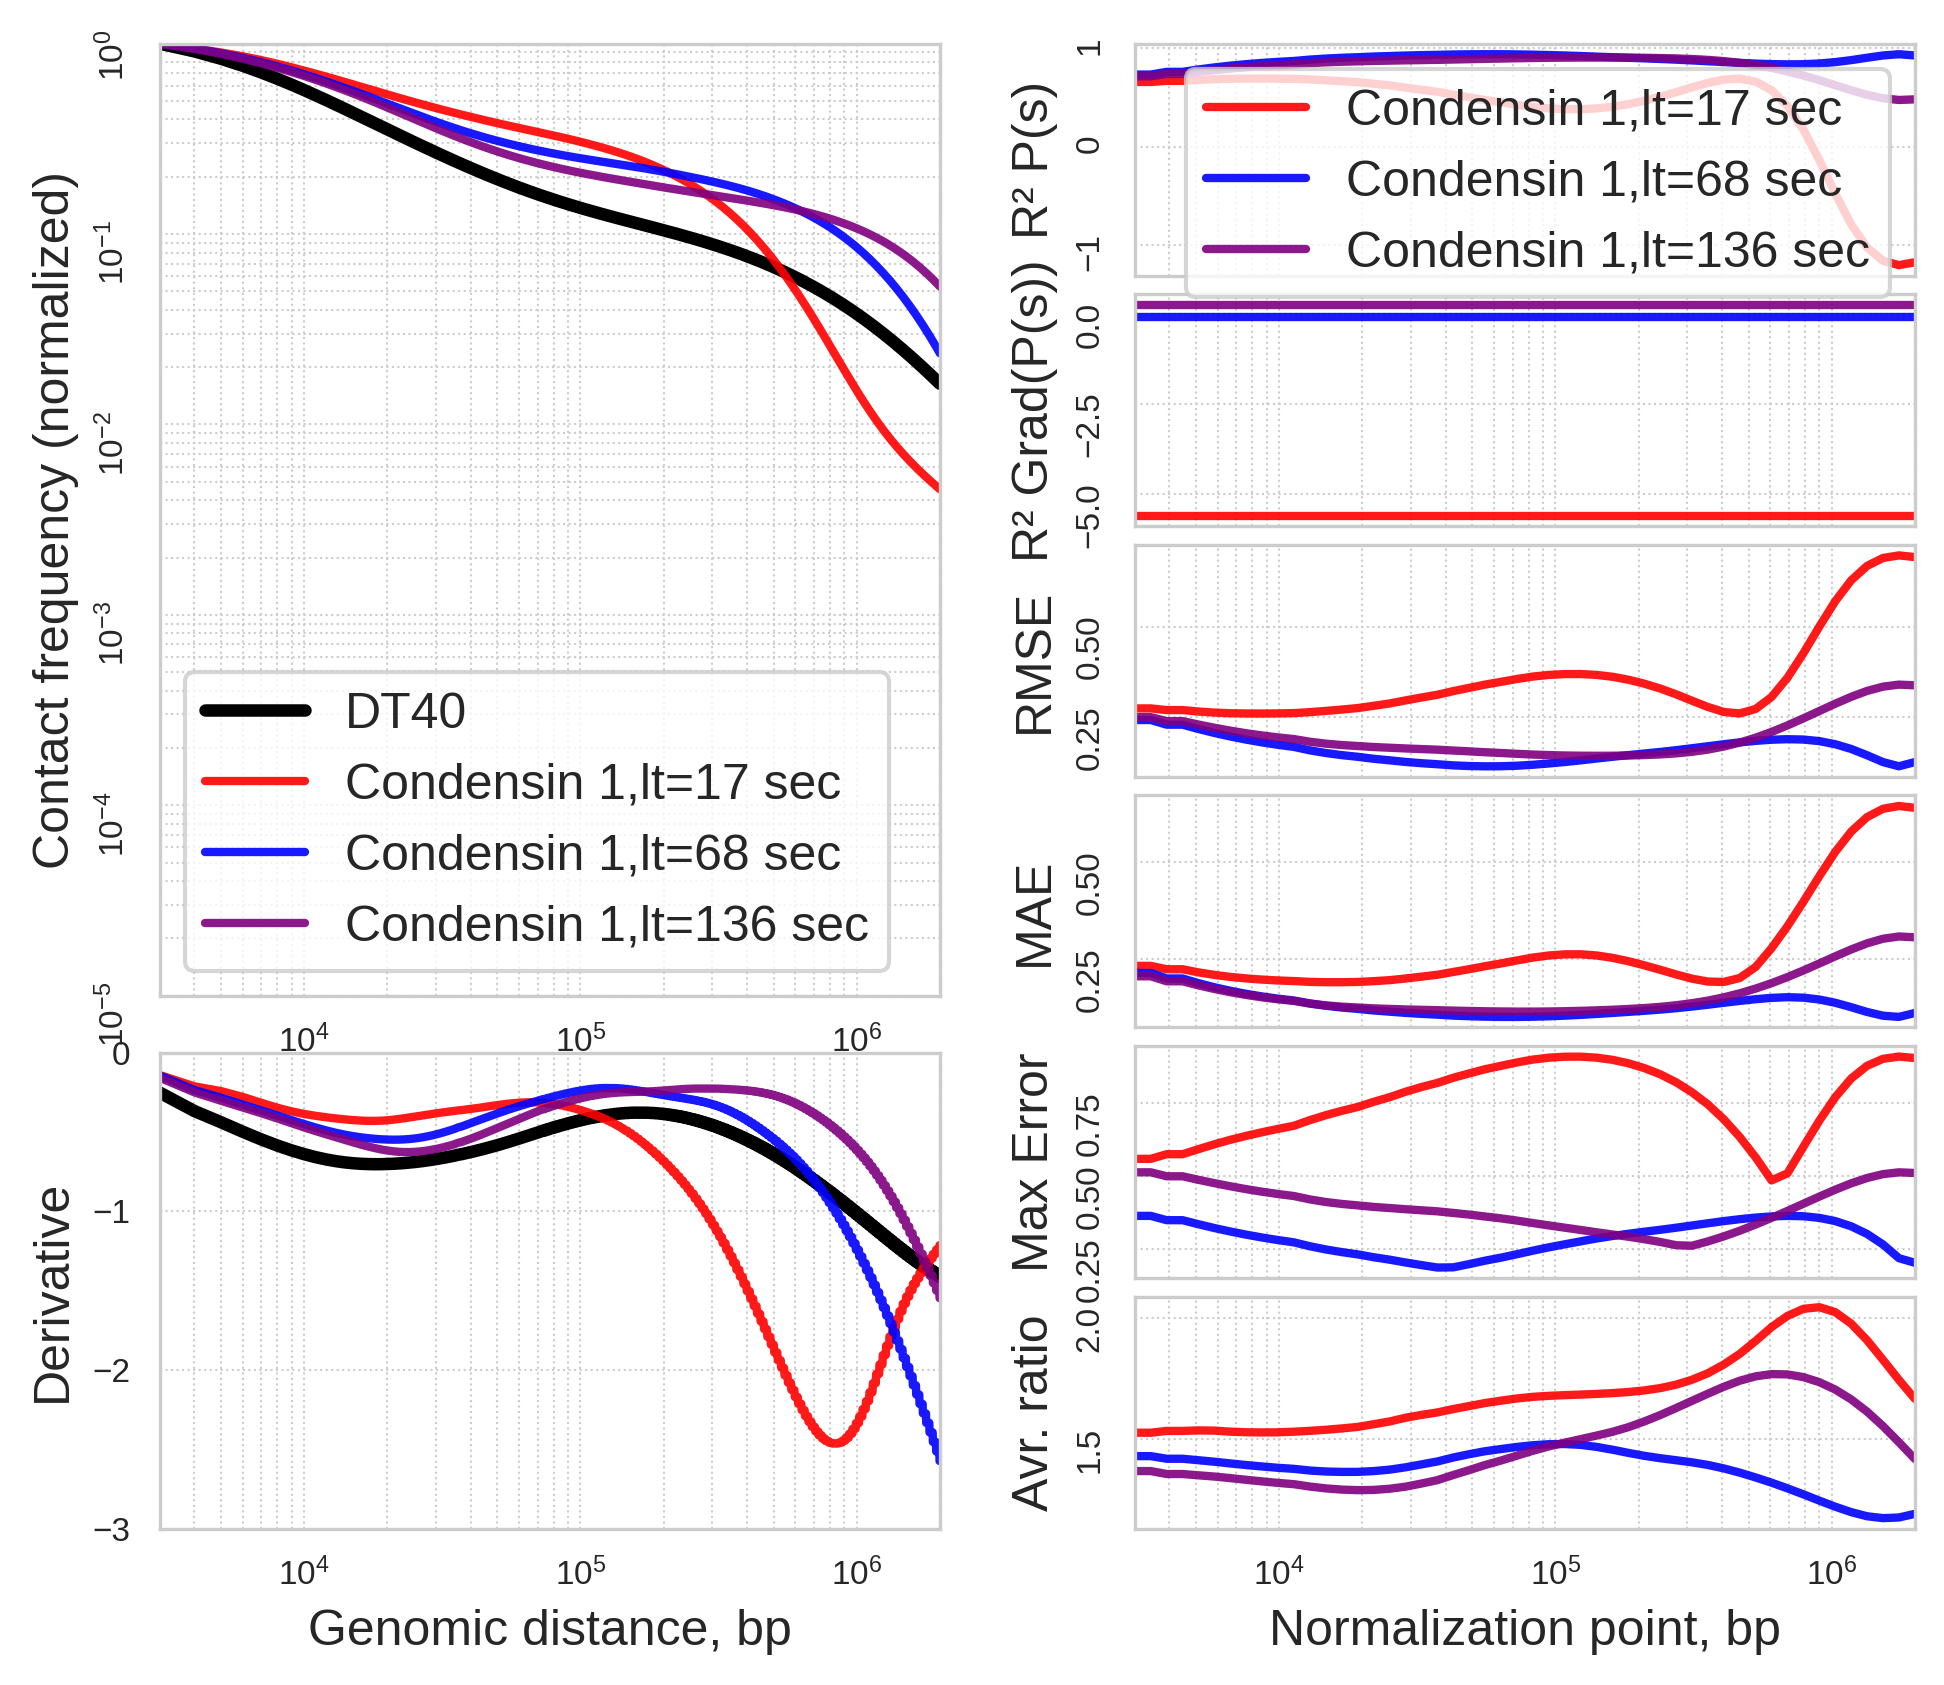

✓ S1 Fig saved as /storage2/vvkonstantinov/Re_model/article_code/figures/S1_Effect_of_extruder_lifetime_Ps_and_metrics.svg


In [5]:
# ===== S1 Fig: Effect of extruder lifetime on contact probability P(s) profiles =====
print("\n[S1 Fig] Effect of extruder lifetime on contact probability P(s) profiles")
print("=" * 60)

# S1 Fig: Static (grey) + Dynamic with three lifetimes (red, blue, purple)
s1_datasets = {
    'DT40': {
        'csv_path': DATA_FOR_FIGS_DIR / 'DT40_experimental.csv',
        'color': 'black',
        'style': 'solid',
        'alpha': 1.0
    },
    'Condensin 1,lt=17 sec': {
        'csv_path': DATA_FOR_FIGS_DIR / 'cond1_gol_p_plen3_dynamic_lt_1div6_sigma200.csv',
        'color': 'red',  # Red line for 17 sec
        'style': 'solid',
        'alpha': 0.9
    },
    'Condensin 1,lt=68 sec': {
        'csv_path': DATA_FOR_FIGS_DIR / 'cond1_gol_p_plen3_dynamic_lt_4div6_sigma200.csv',
        'color': 'blue',  # Blue line for 68 sec
        'style': 'solid',
        'alpha': 0.9
    },
    'Condensin 1,lt=136 sec': {
        'csv_path': DATA_FOR_FIGS_DIR / 'cond1_gol_p_plen3_dynamic_lt_8div6_sigma200.csv',
        'color': 'purple',  # Purple line for 136 sec
        'style': 'solid',
        'alpha': 0.9
    }
}

print("Loading datasets...")

if len(s1_datasets) >= 2:
    print("Creating S1 figure (P(s) + Metrics)...")
    fig = plot_combined_ps_and_metrics(s1_datasets, **PLOT_KW_FIG1)
    fig_path = FIGURES_DIR / 'S1_Effect_of_extruder_lifetime_Ps_and_metrics.svg'
    plt.savefig(fig_path, format='svg', bbox_inches='tight')
    plt.show()
    print(f"✓ S1 Fig saved as {fig_path}")
else:
    print("✗ Need at least 2 datasets for S1 Fig.")
    print(f"   Loaded: {list(s1_datasets.keys())}")



[S2 Fig] Effect of extruder lifetime free loops on contact probability P(s) profiles
Loading datasets...
Creating S2 figure (P(s) + Metrics)...
Analyzing metrics across 50 normalization points...
[50/50] 2000000.0000000002 bp


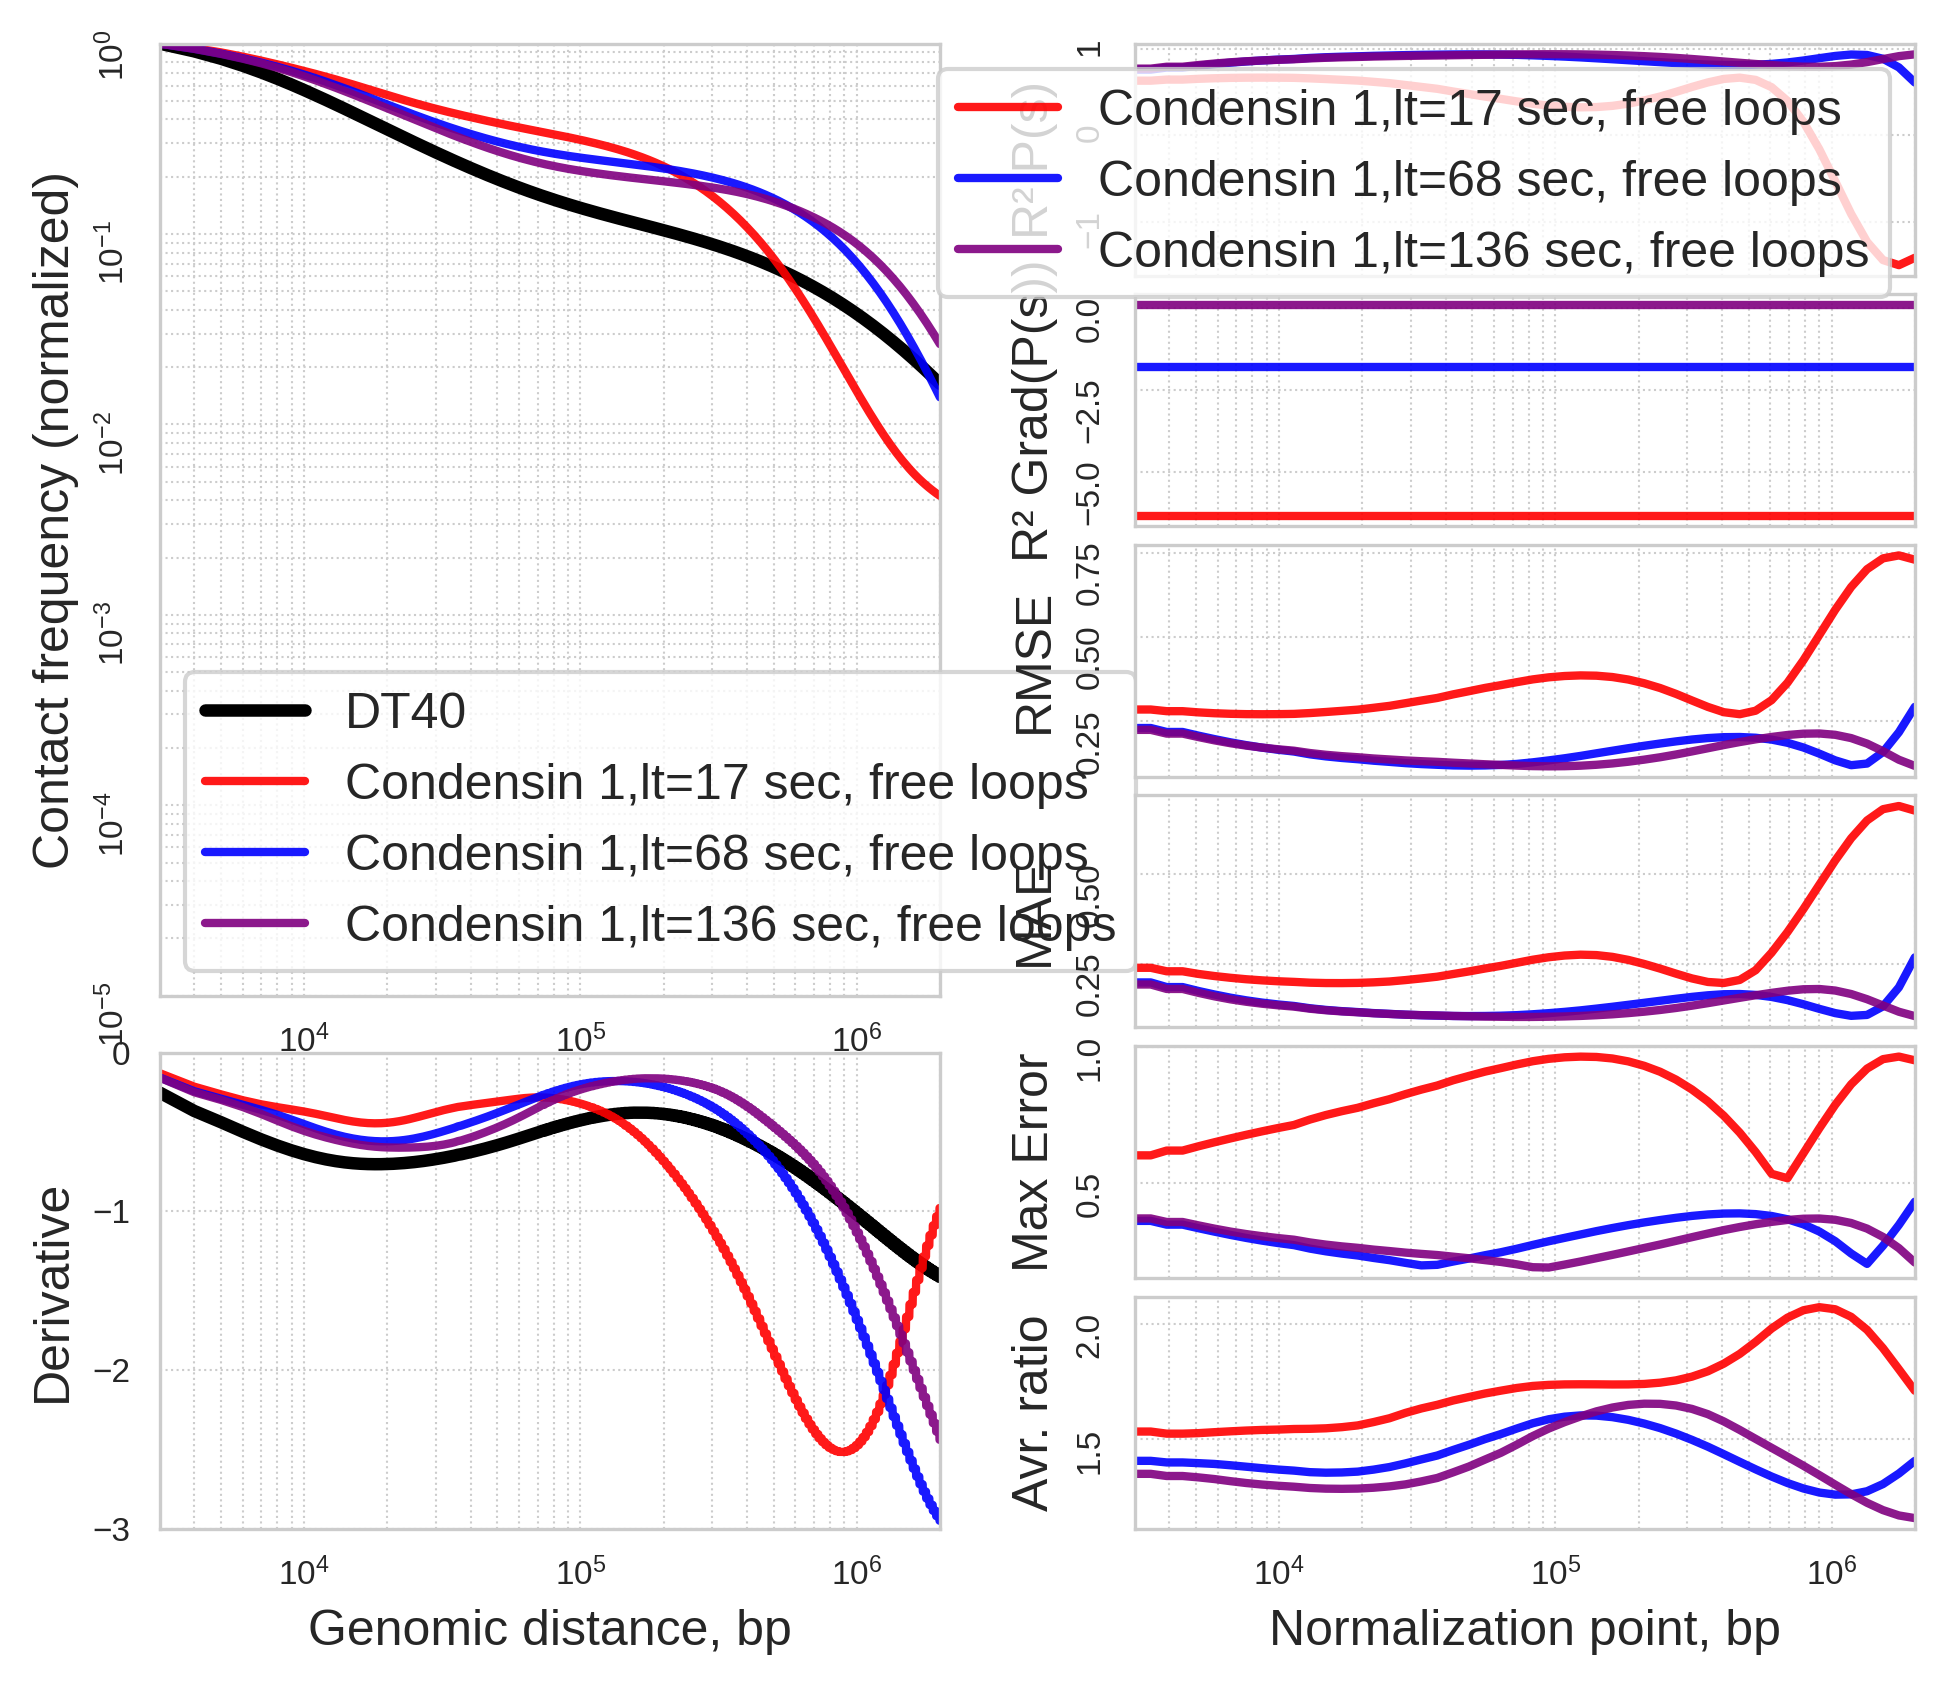

✓ S2 Fig saved as /storage2/vvkonstantinov/Re_model/article_code/figures/S2_Effect_of_extruder_lifetime_free_loops_Ps_and_metrics.svg


In [6]:
# ===== S2 Fig: Effect of extruder lifetime free loops (unnested) =====
print("\n[S2 Fig] Effect of extruder lifetime free loops on contact probability P(s) profiles")
print("=" * 60)

# S2 Fig: Static (grey) + Dynamic unnested with three lifetimes (red, blue, purple)
s2_datasets = {
    'DT40': {
        'csv_path': DATA_FOR_FIGS_DIR / 'DT40_experimental.csv',
        'color': 'black',
        'style': 'solid',
        'alpha': 1.0
    },
    'Condensin 1,lt=17 sec, free loops': {
        'csv_path': DATA_FOR_FIGS_DIR / 'cond1_gol_p_plen3_dynamic_lt_1div6_unnested_sigma200.csv',
        'color': 'red',  # Red line for 17 sec
        'style': 'solid',
        'alpha': 0.9
    },
    'Condensin 1,lt=68 sec, free loops': {
        'csv_path': DATA_FOR_FIGS_DIR / 'cond1_gol_p_plen3_dynamic_lt_4div6_unnested_sigma200.csv',
        'color': 'blue',  # Blue line for 68 sec
        'style': 'solid',
        'alpha': 0.9
    },
    'Condensin 1,lt=136 sec, free loops': {
        'csv_path': DATA_FOR_FIGS_DIR / 'cond1_gol_p_plen3_dynamic_lt_8div6_unnested_sigma200.csv',
        'color': 'purple',  # Purple line for 136 sec
        'style': 'solid',
        'alpha': 0.9
    }
}

print("Loading datasets...")

if len(s2_datasets) >= 2:
    print("Creating S2 figure (P(s) + Metrics)...")
    fig = plot_combined_ps_and_metrics(s2_datasets, **PLOT_KW_FIG1)
    fig_path = FIGURES_DIR / 'S2_Effect_of_extruder_lifetime_free_loops_Ps_and_metrics.svg'
    plt.savefig(fig_path, format='svg', bbox_inches='tight')
    plt.show()
    print(f"✓ S2 Fig saved as {fig_path}")
else:
    print("✗ Need at least 2 datasets for S2 Fig.")
    print(f"   Loaded: {list(s2_datasets.keys())}")



[S3 Fig] Effect of extruder lifetime free loops with loop size distributions
Loading datasets...
Creating S3 figure (P(s) + Loop distributions)...


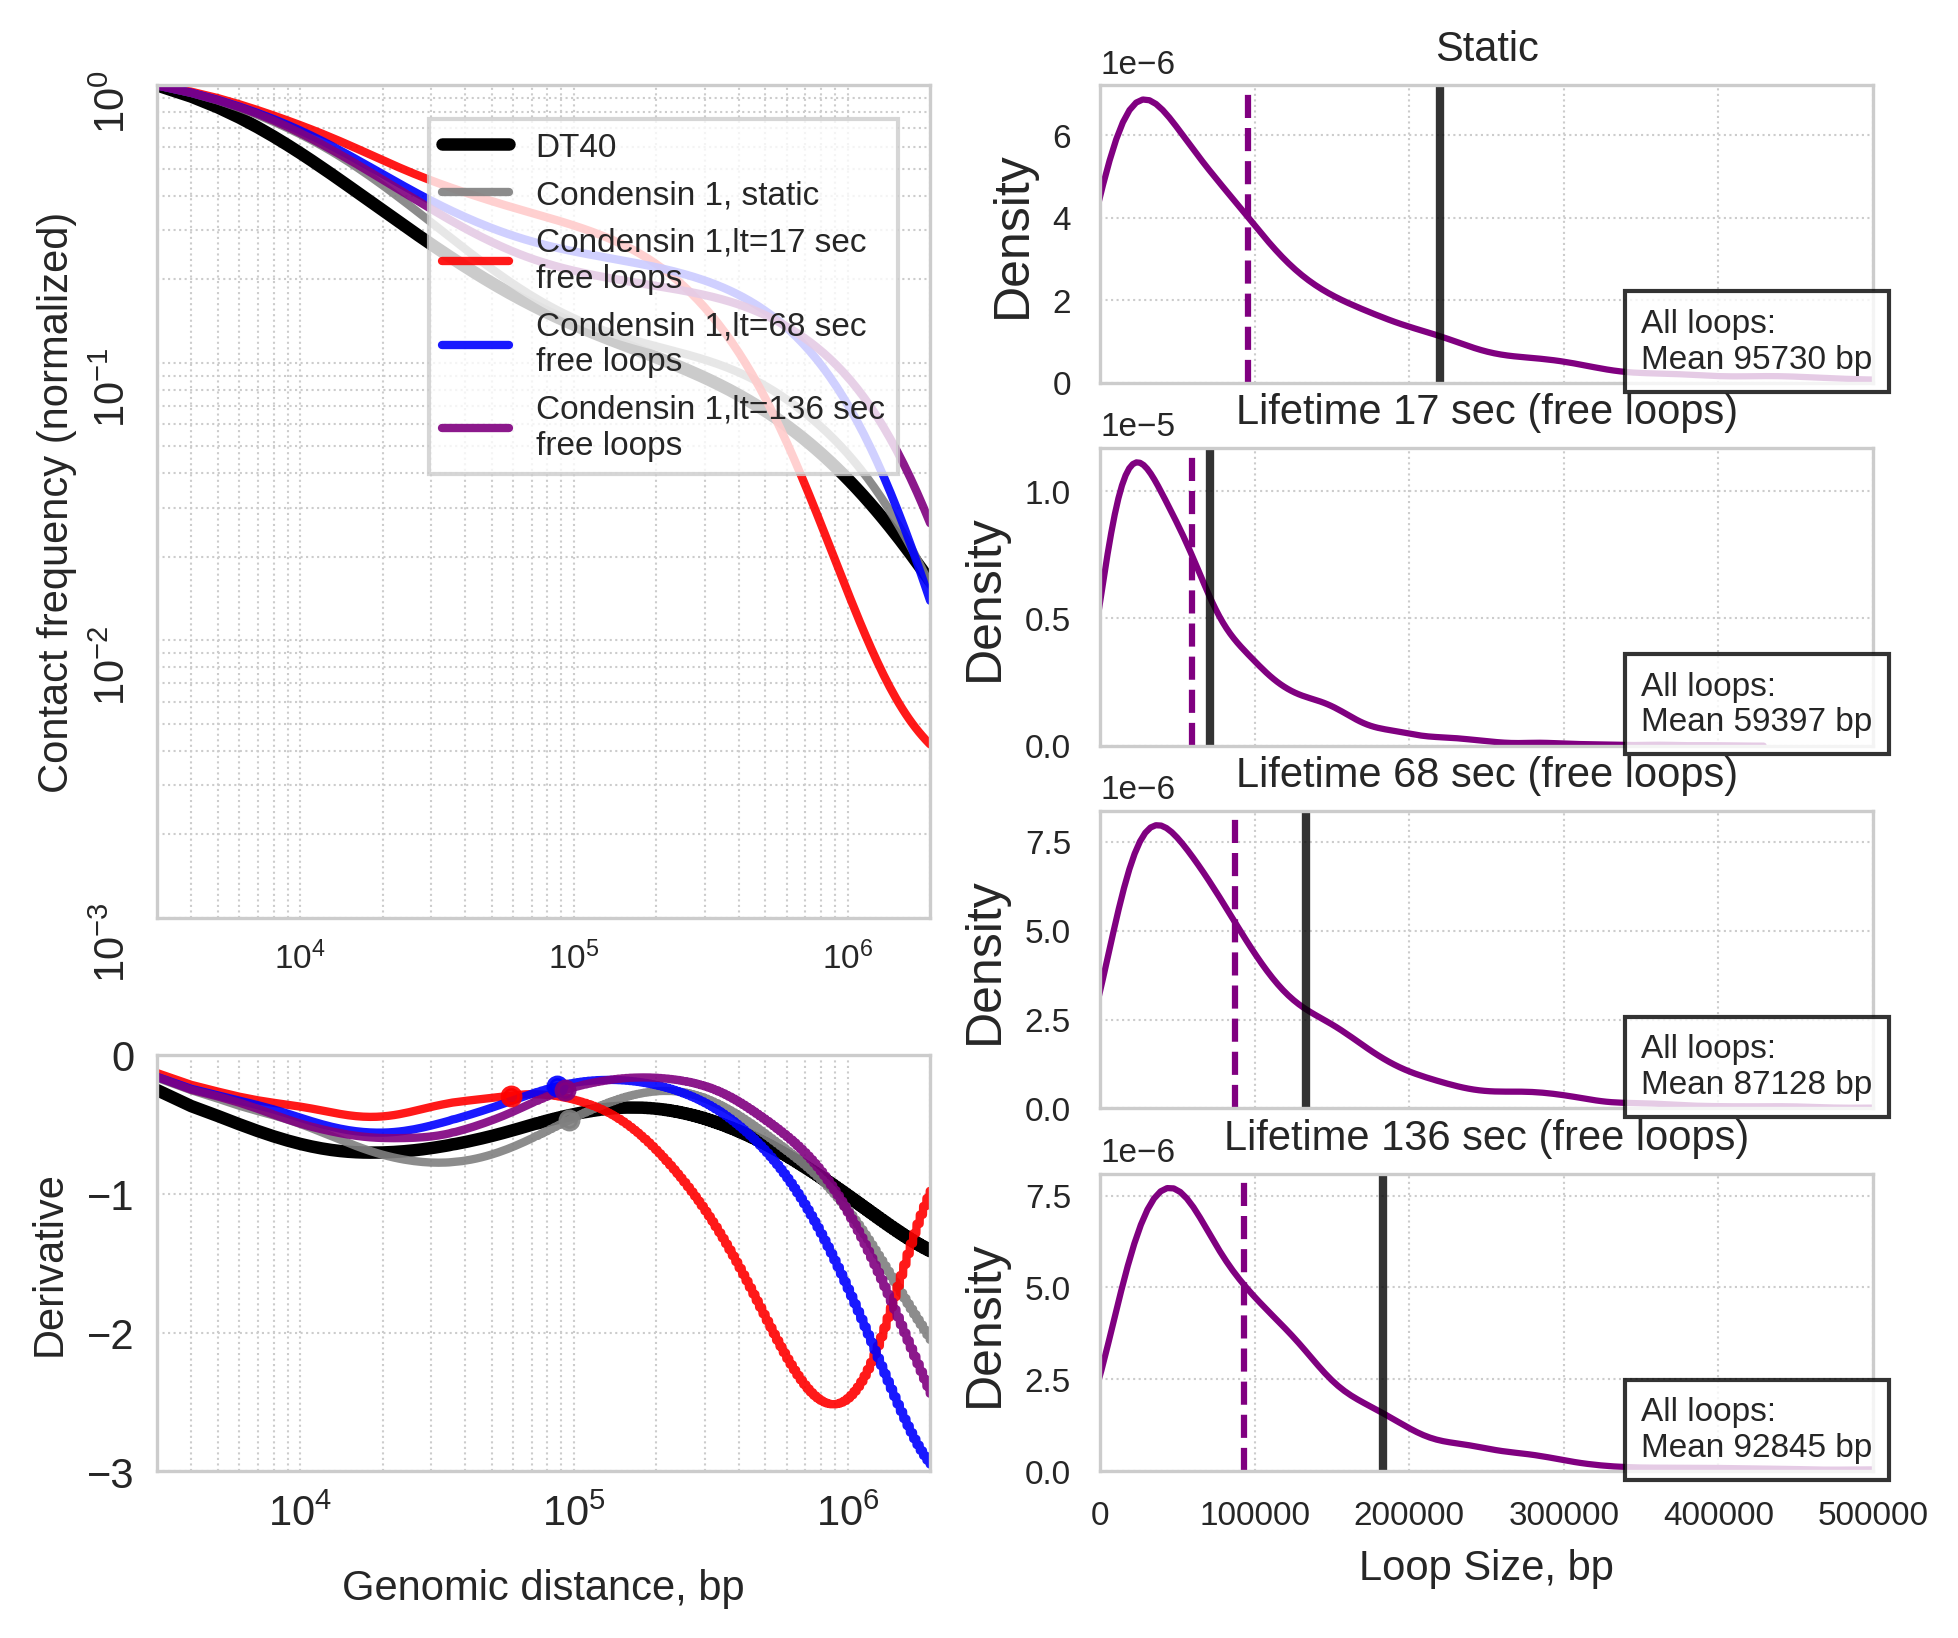

✓ S3 Fig saved as /storage2/vvkonstantinov/Re_model/article_code/figures/S3_Effect_of_extruder_lifetime_free_loops_Ps_and_loops.svg


In [7]:
# ===== S3 Fig: Effect of extruder lifetime free loops with loop size distributions =====
print("\n[S3 Fig] Effect of extruder lifetime free loops with loop size distributions")
print("=" * 60)

# S3 Fig: Static (grey) + Dynamic unnested with three lifetimes (red, blue, purple) + loop distributions
s3_datasets = {
    'DT40': {
        'csv_path': DATA_FOR_FIGS_DIR / 'DT40_experimental.csv',
        'color': 'black',
        'style': 'solid',
        'alpha': 1.0
    },
    'Condensin 1, static': {
        'csv_path': DATA_FOR_FIGS_DIR / 'cond1_gol_p_plen3_sigma200.csv',
        'color': 'grey',  # Grey line for static
        'style': 'solid',
        'alpha': 0.9
    },
    'Condensin 1,lt=17 sec, free loops': {
        'csv_path': DATA_FOR_FIGS_DIR / 'cond1_gol_p_plen3_dynamic_lt_1div6_unnested_sigma200.csv',
        'color': 'red',  # Red line for 17 sec
        'style': 'solid',
        'alpha': 0.9
    },
    'Condensin 1,lt=68 sec, free loops': {
        'csv_path': DATA_FOR_FIGS_DIR / 'cond1_gol_p_plen3_dynamic_lt_4div6_unnested_sigma200.csv',
        'color': 'blue',  # Blue line for 68 sec
        'style': 'solid',
        'alpha': 0.9
    },
    'Condensin 1,lt=136 sec, free loops': {
        'csv_path': DATA_FOR_FIGS_DIR / 'cond1_gol_p_plen3_dynamic_lt_8div6_unnested_sigma200.csv',
        'color': 'purple',  # Purple line for 136 sec
        'style': 'solid',
        'alpha': 0.9
    }
}

print("Loading datasets...")

# Create S3 figure with P(s) + Loop distributions
loops_base_dir = PROJECT_ROOT / "coolmaps" / "draw_ps_article"
if loops_base_dir.exists() and len(s3_datasets) >= 2:
    print("Creating S3 figure (P(s) + Loop distributions)...")
    try:
        fig_loops = plot_combined_ps_and_loops(
            s3_datasets,
            x_limits=(3e3, 2e6),
            y1_limits=(1e-3, 1e0),  # Match S1/S2 y1_limits
            y2_limits=(-3, 0.),
            normalize=True,
            alignment_s_bp=3000,
            loops_base_dir=str(loops_base_dir),
            bead_size=200,
            max_distance_beads=2500,
            figsize=(6.5, 5.5),
            dpi=300
        )
        fig_path_loops = FIGURES_DIR / 'S3_Effect_of_extruder_lifetime_free_loops_Ps_and_loops.svg'
        plt.savefig(fig_path_loops, format='svg', bbox_inches='tight')
        plt.show()
        print(f"✓ S3 Fig saved as {fig_path_loops}")
    except Exception as e:
        print(f"⚠ Could not create S3 loop distributions figure: {e}")
        import traceback
        traceback.print_exc()
        print("   This requires loop statistics data files in the loops_base_dir")
        # Fallback: create P(s) + Metrics figure instead
        print("\nCreating S3 figure (P(s) + Metrics) as fallback...")
        fig = plot_combined_ps_and_metrics(s3_datasets, **PLOT_KW_FIG1)
        fig_path = FIGURES_DIR / 'S3_Effect_of_extruder_lifetime_free_loops_Ps_and_metrics.svg'
        plt.savefig(fig_path, format='svg', bbox_inches='tight')
        plt.show()
        print(f"✓ S3 Fig (fallback) saved as {fig_path}")
else:
    if not loops_base_dir.exists():
        print(f"⚠ Loops base directory not found: {loops_base_dir}")
        print("   Creating S3 figure (P(s) + Metrics) instead...")
        if len(s3_datasets) >= 2:
            fig = plot_combined_ps_and_metrics(s3_datasets, **PLOT_KW_FIG1)
            fig_path = FIGURES_DIR / 'S3_Effect_of_extruder_lifetime_free_loops_Ps_and_metrics.svg'
            plt.savefig(fig_path, format='svg', bbox_inches='tight')
            plt.show()
            print(f"✓ S3 Fig (P(s) + Metrics) saved as {fig_path}")
        else:
            print("✗ Need at least 2 datasets for S3 Fig.")
            print(f"   Loaded: {list(s3_datasets.keys())}")
    else:
        print("✗ Need at least 2 datasets for S3 Fig.")
        print(f"   Loaded: {list(s3_datasets.keys())}")


### A1 Fig. Effect of spatial displacement noise value with "Step potential" on contact probability P(s) profiles

**A)** Smoothing of P(s) model curves with different sigma-noises in range 3 kbp - 2 Mbp for experimental data for chicken cells line DT40 (black line), aggregated model data for Step potential (sigma-noises: 50, 100, 200, 400 nm).

**B)** Results of comparing segments experiment P(s) vs model data with shifting normalisation point on different metrics. The normalization point shifts within the range of 3 kbp to 2 Mbp. The comparable segment of the plot is 3 kbp-2 Mbp.

### A2 Fig. Effect of spatial displacement noise value with "DPD potential" on contact probability P(s) profiles

**A)** Smoothing of P(s) model curves with different sigma-noises in range 3 kbp - 2 Mbp for experimental data for chicken cells line DT40 (black line), aggregated model data for DPD potential (sigma-noises: 50, 100, 200, 400 nm).

**B)** Results of comparing segments experiment P(s) vs model data with shifting normalisation point on different metrics. The normalization point shifts within the range of 3 kbp to 2 Mbp. The comparable segment of the plot is 3 kbp-2 Mbp.

### A3 Fig. Effect of the bead number shift on Spiral correlation C(s) profiles

Spiral correlation C(s) for different vector step sizes d including ideal spirals. Each subplot shows C(s) as a function of genomic distance s (in bp) for a fixed d. Gray lines: Analytical result for ideal spirals with pitches 1×10^6 and 1×10^7 bp, serving as periodic references. Red lines: Averaged C(s) for simulated model chromosomes. Purple/Blue lines: Experimental data for SMC3-CAPH2KO and SMC3KO.



[A1 Fig] Effect of spatial displacement noise value with Step potential
Loading datasets...
Creating A1 figure (P(s) + Metrics)...
Analyzing metrics across 50 normalization points...
[50/50] 2000000.0000000002 bp


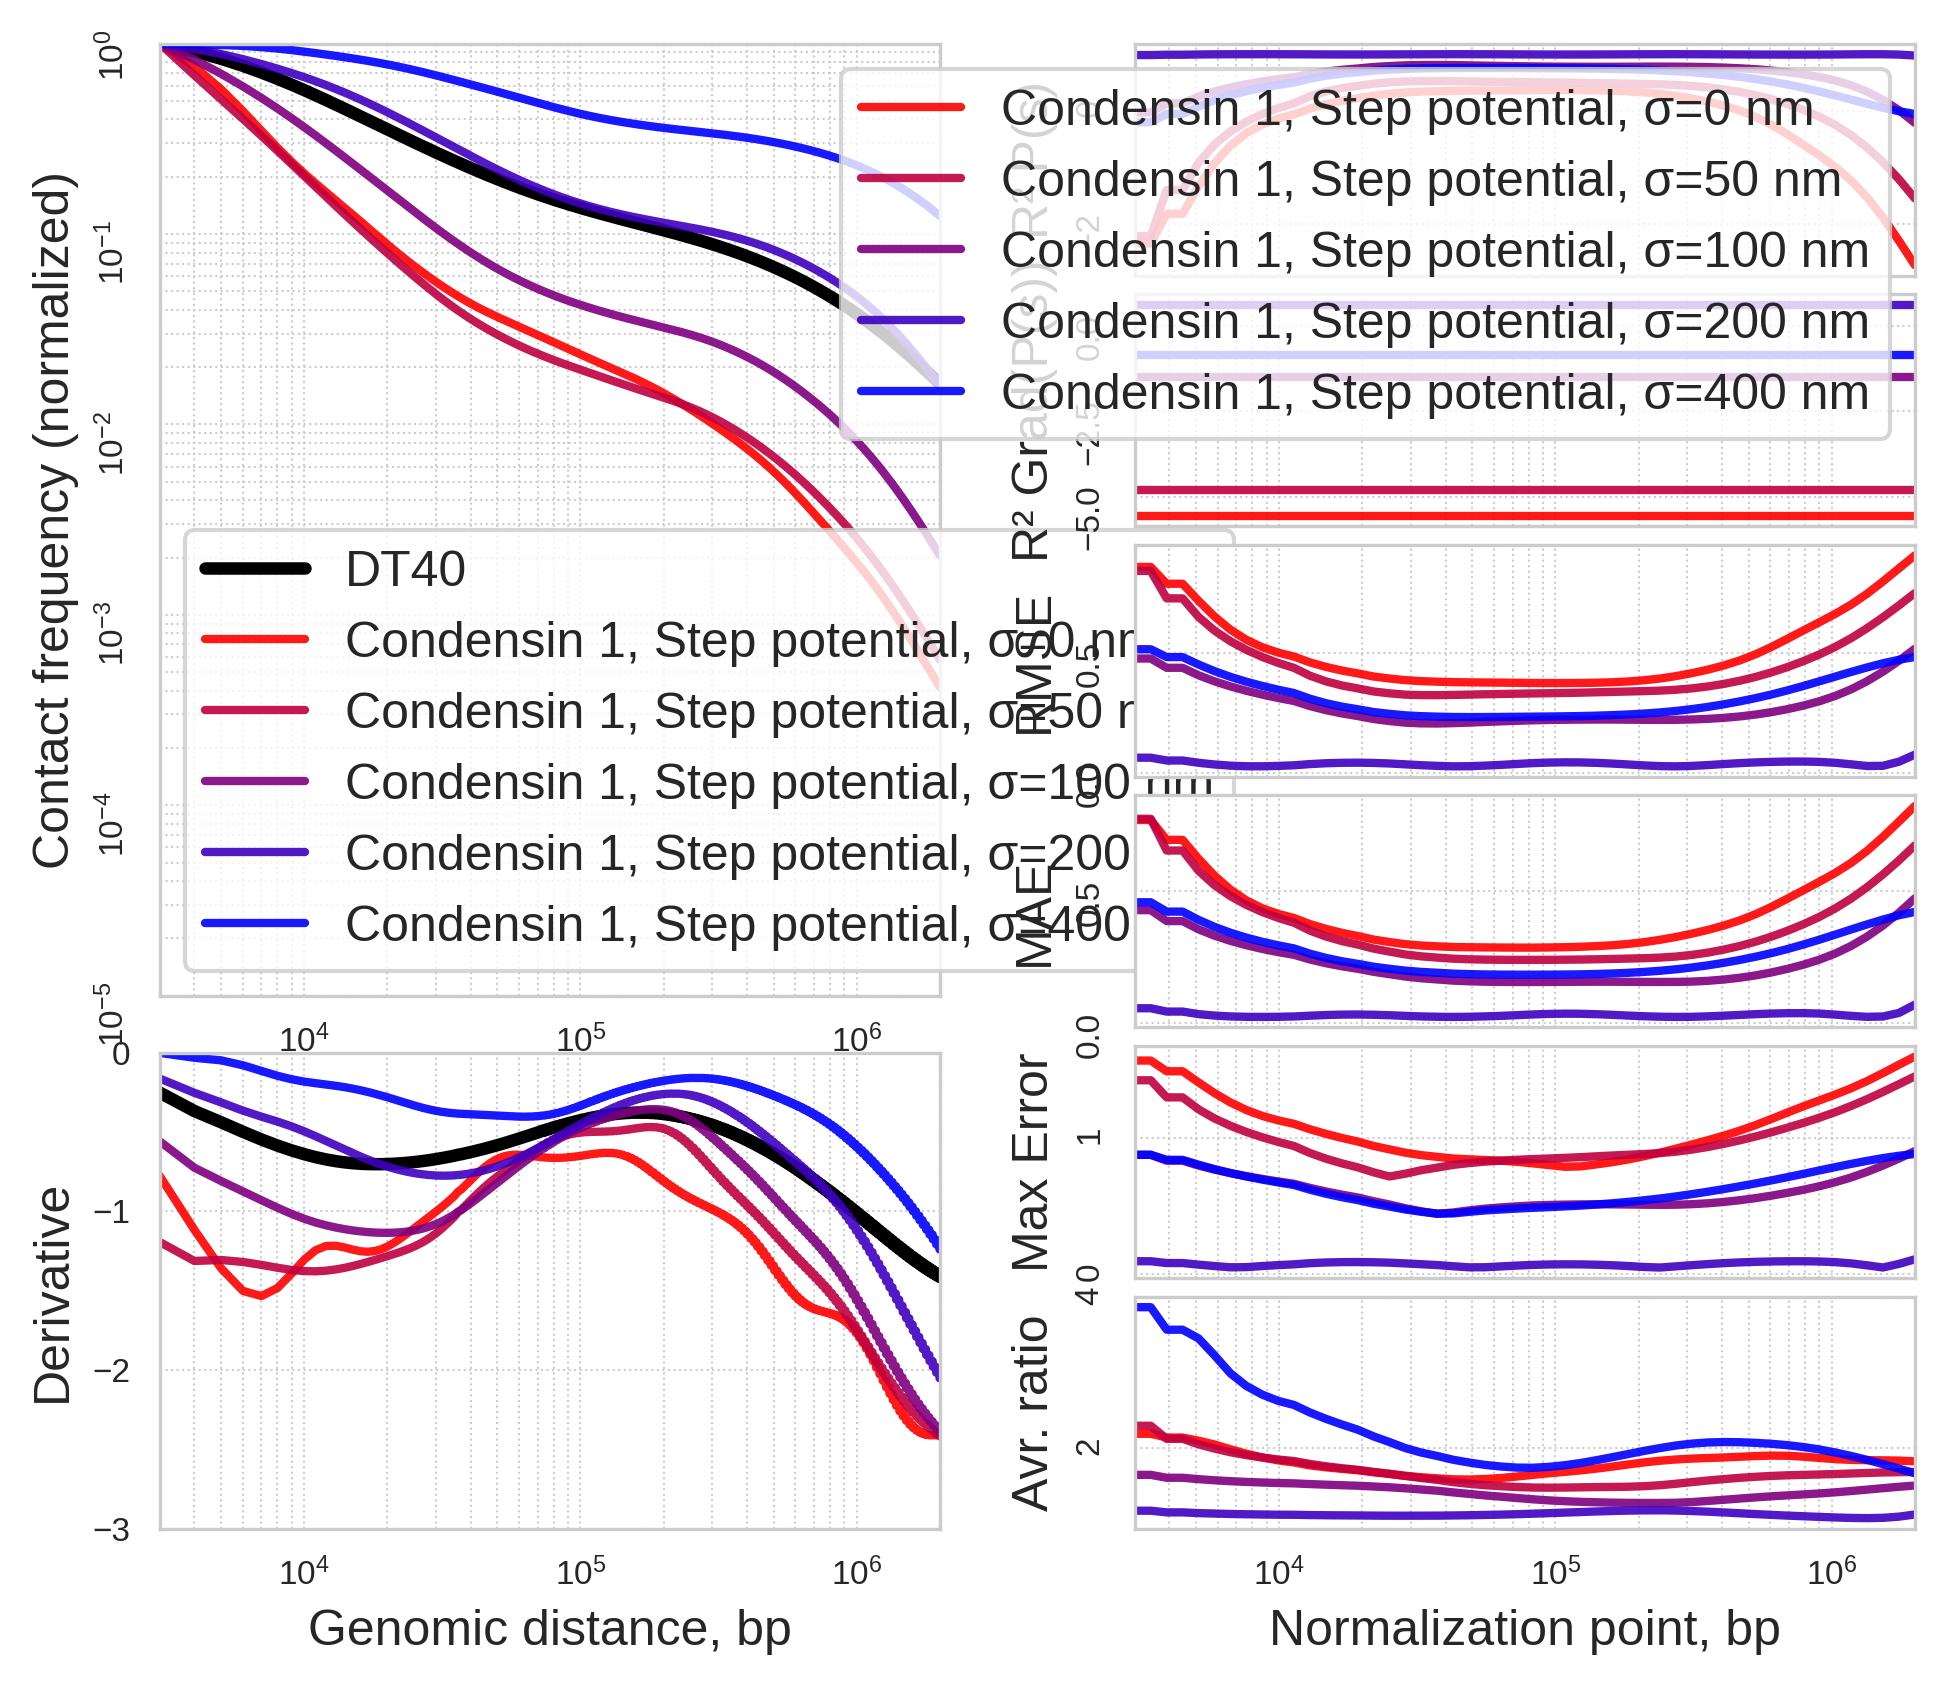

✓ A1 Fig saved as /storage2/vvkonstantinov/Re_model/article_code/figures/A1_Effect_of_sigma_noise_Step_potential.svg


In [8]:
# ===== A1 Fig: Effect of sigma noise on Step potential =====
print("\n[A1 Fig] Effect of spatial displacement noise value with Step potential")
print("=" * 60)

# A1 Fig: DT40 + Step potential with different sigma values (50, 100, 200, 400 nm)
# Using gradient color palette for different sigma values
sigma_values = [0, 50, 100, 200, 400]
sigma_palette = sns.color_palette('blend:red,purple,blue', n_colors=len(sigma_values)).as_hex()

a1_datasets = {
    'DT40': {
        'csv_path': DATA_FOR_FIGS_DIR / 'DT40_experimental.csv',
        'color': 'black',
        'style': 'solid',
        'alpha': 1.0
    }
}

for i, sigma in enumerate(sigma_values):
    a1_datasets[f'Condensin 1, Step potential, σ={sigma} nm'] = {
        'csv_path': DATA_FOR_FIGS_DIR / f'cond1_gol_p_plen3_sigma{sigma}.csv',
        'color': sigma_palette[i],
        'style': 'solid',
        'alpha': 0.9
    }

print("Loading datasets...")

if len(a1_datasets) >= 2:
    print("Creating A1 figure (P(s) + Metrics)...")
    fig = plot_combined_ps_and_metrics(a1_datasets, **PLOT_KW_FIG1)
    fig_path = FIGURES_DIR / 'A1_Effect_of_sigma_noise_Step_potential.svg'
    plt.savefig(fig_path, format='svg', bbox_inches='tight')
    plt.show()
    print(f"✓ A1 Fig saved as {fig_path}")
else:
    print("✗ Need at least 2 datasets for A1 Fig.")
    print(f"   Loaded: {list(a1_datasets.keys())}")



[A2 Fig] Effect of spatial displacement noise value with DPD potential
Loading datasets...
Creating A2 figure (P(s) + Metrics)...


Analyzing metrics across 50 normalization points...
[50/50] 2000000.0000000002 bp


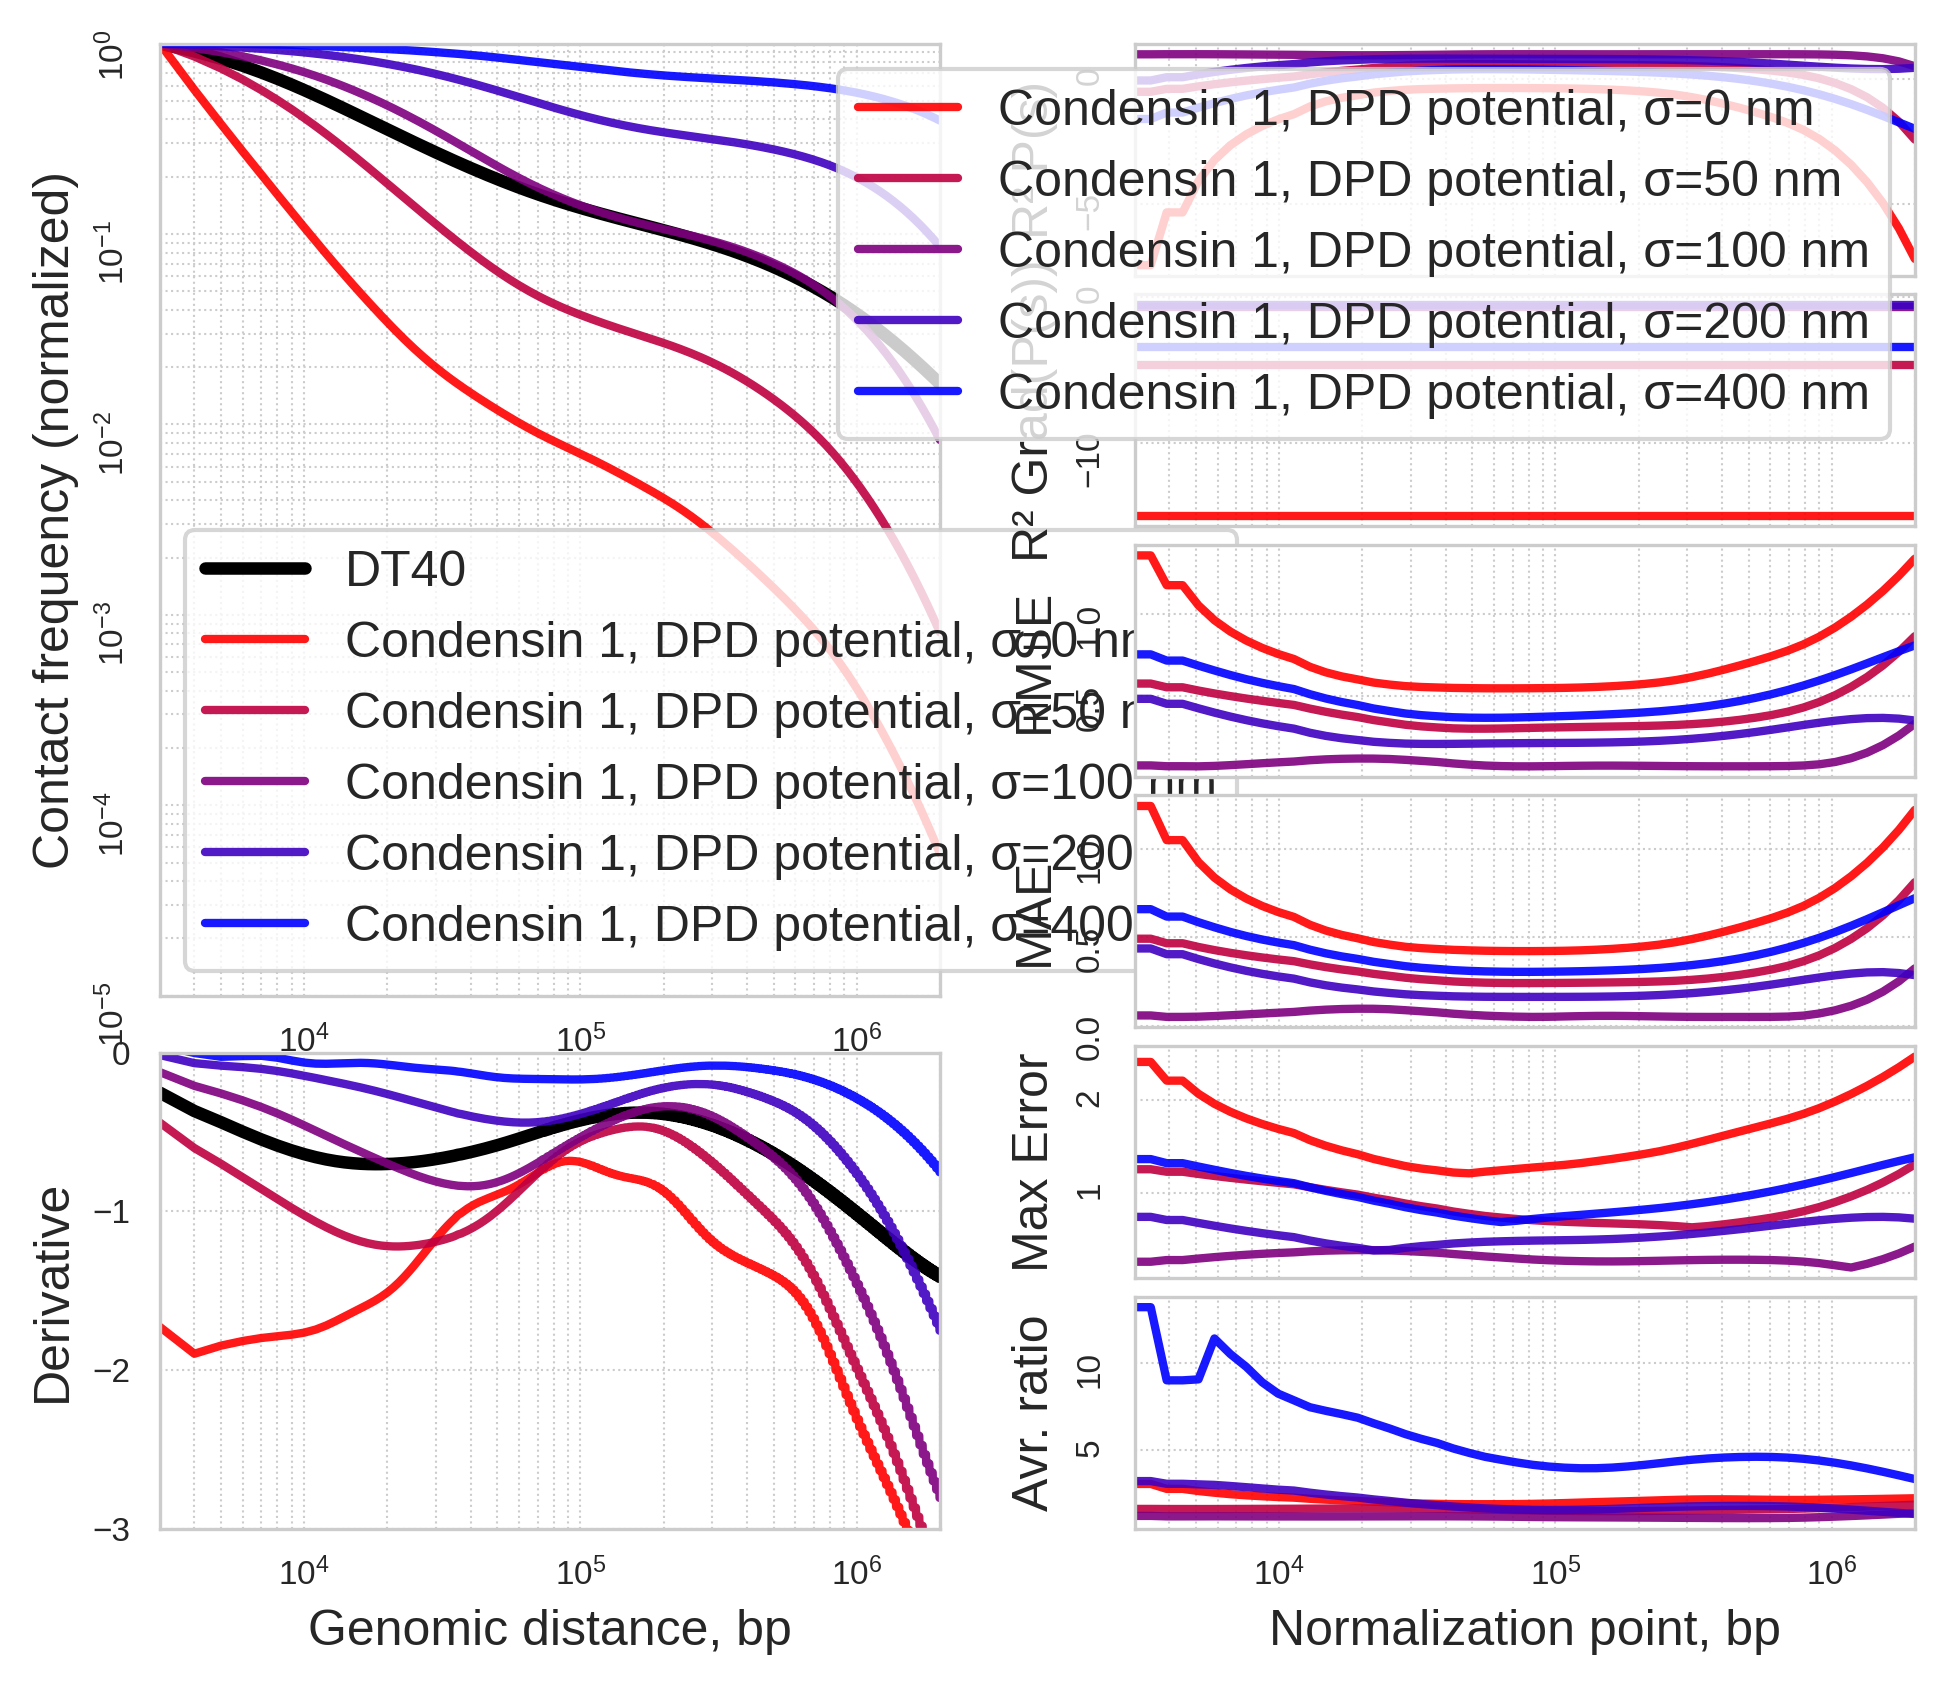

✓ A2 Fig saved as /storage2/vvkonstantinov/Re_model/article_code/figures/A2_Effect_of_sigma_noise_DPD_potential.svg


In [9]:
# ===== A2 Fig: Effect of sigma noise on DPD potential =====
print("\n[A2 Fig] Effect of spatial displacement noise value with DPD potential")
print("=" * 60)

# A2 Fig: DT40 + DPD potential with different sigma values (50, 100, 200, 400 nm)
# Using gradient color palette for different sigma values
sigma_values = [0, 50, 100, 200, 400]
sigma_palette = sns.color_palette('blend:red,purple,blue', n_colors=len(sigma_values)).as_hex()

a2_datasets = {
    'DT40': {
        'csv_path': DATA_FOR_FIGS_DIR / 'DT40_experimental.csv',
        'color': 'black',
        'style': 'solid',
        'alpha': 1.0
    }
}

for i, sigma in enumerate(sigma_values):
    a2_datasets[f'Condensin 1, DPD potential, σ={sigma} nm'] = {
        'csv_path': DATA_FOR_FIGS_DIR / f'cond1_gol_p_plen0_dpdforce_sigma{sigma}.csv',
        'color': sigma_palette[i],
        'style': 'solid',
        'alpha': 0.9
    }

print("Loading datasets...")

if len(a2_datasets) >= 2:
    print("Creating A2 figure (P(s) + Metrics)...")
    fig = plot_combined_ps_and_metrics(a2_datasets, **PLOT_KW_FIG1)
    fig_path = FIGURES_DIR / 'A2_Effect_of_sigma_noise_DPD_potential.svg'
    plt.savefig(fig_path, format='svg', bbox_inches='tight')
    plt.show()
    print(f"✓ A2 Fig saved as {fig_path}")
else:
    print("✗ Need at least 2 datasets for A2 Fig.")
    print(f"   Loaded: {list(a2_datasets.keys())}")


### Implementation

The following cell creates A3 Fig using functions from `spiral_metrics.py`:
- `compute_C_s`: Computes spiral correlation C(s) for different vector step sizes d
- `generate_cylindrical_spiral`: Generates ideal spiral references

The figure compares:
- Gray lines: Ideal spirals with pitches 1×10^6 and 1×10^7 bp
- Red line: Simulated model chromosomes (Step potential) - **data not available**
- Purple/Blue lines: Experimental data (SMC3-CAPH2KO and SMC3KO)

### Important Note on Goloborodko Data

For spiral correlation analysis, we used data from static extruder models published in the article by Samejima et al. (DOI: 10.1126/science.adq1709). However, the data storage format in their work is unconventional from our perspective.

**Periodic Boundary Conditions (PBC) Issue:**
- All beads are packed inside a PBC box, where particles exiting one boundary "teleport" to the opposite side
- Instead of an unfolded chromosome structure, the data represents a parallelepiped
- To unfold this structure, additional functions are required (which we could not find in the original article)
- See `prepare_goloborodko_data.py` for the unfolding implementation

**Contact Map Implications:**
- Contact maps assembled before and after unfolding show differences for long-range contacts
- This is expected, as distant contacts were artificially brought together by PBC wrapping
- The validity of this approach is not entirely obvious or fully acceptable from our perspective.
- **Important**: In the original work, P(s) curves were calculated from non-unfolded data, as far as we can determine

**Available Data:**
- The `goloborodko_data/` folder contains both folded and unfolded positions:
  - `*_positions_*.npy` - Unfolded positions (used for A3 Fig)
  - `*_unfolded_positions_*.npy` - Alternative unfolded version



[A3 Fig] Effect of the bead number shift on Spiral correlation C(s) profiles
Processing d=2000 (1/4)...
Processing d=4000 (2/4)...
Processing d=8000 (3/4)...
Processing d=32000 (4/4)...


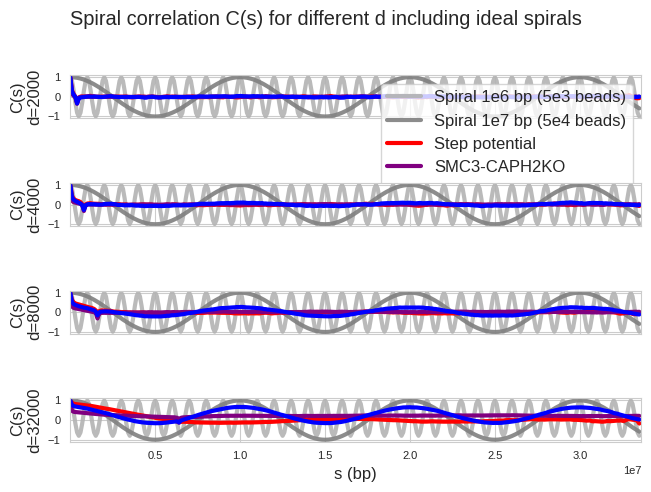

✓ A3 Fig saved as /storage2/vvkonstantinov/Re_model/article_code/figures/A3_Spiral_correlation_Cs_profiles.svg


In [ ]:
# ===== A3 Fig: Spiral correlation C(s) for different vector step sizes =====
print("\n[A3 Fig] Effect of the bead number shift on Spiral correlation C(s) profiles")
print("=" * 60)

# Parameters
ds = [2000, 4000, 8000, 32000]  # Vector step sizes (d) in beads
step_s = 500
min_s = 1
max_s = 200000 - max(ds)
radius = 10.0
pitch = 1.0
bp_in_bead = 200

# Create figure with subplots for each d value
fig, axs = plt.subplots(len(ds), 1, figsize=(6.67, 5), sharex=True)

# Generate ideal spirals for reference
beads_per_turn_1 = int(1e7 / bp_in_bead)  # Pitch 1e7 bp
total_points_1 = 500000
beads_per_turn_2 = int(1e6 / bp_in_bead)  # Pitch 1e6 bp
total_points_2 = 500000

spiral1 = generate_cylindrical_spiral(total_points_1, beads_per_turn_1, radius, pitch)
spiral2 = generate_cylindrical_spiral(total_points_2, beads_per_turn_2, radius, pitch)

C_s_ideal_1 = {}
C_s_ideal_2 = {}

# Process each vector step size d
for idx, d in enumerate(ds):
    print(f"Processing d={d} ({idx+1}/{len(ds)})...")
    
    # 1. Simulated model chromosomes (Step potential)
    C_s_all_model = []
    cells_dir = PROJECT_ROOT / "article_code" / "cells_cond1_gol_p_plen3"
    
    for cell_num in range(5):
        path_to_cell = cells_dir / f'cell_{cell_num}'
        path_to_3D = path_to_cell / '3D_data'
        
        if not path_to_3D.exists():
            print(f"  ⚠ 3D data not found for cell_{cell_num}")
            continue
            
        try:
            URIs = hdf5.list_URIs(str(path_to_3D))[9::10]  # Sample every 10th frame
            polymers = {}
            for uri in URIs:
                polymers[uri.split("::")[-1]] = hdf5.load_URI(uri)
            
            block = '99'
            if block in polymers:
                positions = polymers[block]['pos']
                C_s, s_1 = compute_C_s(positions, d=d, min_s=min_s, max_s=max_s, step_s=step_s)
                C_s_all_model.append(C_s)
        except Exception as e:
            print(f"  ⚠ Error processing cell_{cell_num}: {e}")
            continue
    
    if C_s_all_model:
        C_s_stack_model = np.vstack(C_s_all_model)
        C_s_mean_model = np.mean(C_s_stack_model, axis=0)
    else:
        C_s_mean_model = None
        s_1 = None
    
    # 2. Experimental data - SMC3-CAPH2KO
    goloborodko_dir = ARTICLE_CODE_DIR / "goloborodko_data"
    dataset_group_1 = [
        'SMC3-CAPH2KO_positions_R_0.npy',
        'SMC3-CAPH2KO_positions_R_3.npy',
        'SMC3-CAPH2KO_positions_R_4.npy',
        'SMC3-CAPH2KO_positions_R_5.npy',
    ]
    C_s_all_caph2ko = []
    for fname in dataset_group_1:
        fpath = goloborodko_dir / fname
        if fpath.exists():
            try:
                positions = np.load(fpath)
                C_s, s = compute_C_s(positions, d=d, min_s=min_s, max_s=max_s, step_s=step_s)
                C_s_all_caph2ko.append(C_s)
            except Exception as e:
                print(f"  ⚠ Error loading {fname}: {e}")
        else:
            print(f"  ⚠ File not found: {fpath}")
    
    if C_s_all_caph2ko:
        C_s_stack_caph2ko = np.vstack(C_s_all_caph2ko)
        C_s_mean_caph2ko = np.mean(C_s_stack_caph2ko, axis=0)
    else:
        C_s_mean_caph2ko = None
    
    # 3. Experimental data - SMC3KO
    dataset_group_2 = [
        'SMC3KO_positions_R_0.npy',
        'SMC3KO_positions_R_1.npy',
        'SMC3KO_positions_R_2.npy',
    ]
    C_s_all_smc3ko = []
    for fname in dataset_group_2:
        fpath = goloborodko_dir / fname
        try:
            positions = np.load(fpath)
            C_s, s = compute_C_s(positions, d=d, min_s=min_s, max_s=max_s, step_s=step_s)
            C_s_all_smc3ko.append(C_s)
        except Exception as e:
            print(f"  ⚠ Error loading {fname}: {e}")

    
    if C_s_all_smc3ko:
        C_s_stack_smc3ko = np.vstack(C_s_all_smc3ko)
        C_s_mean_smc3ko = np.mean(C_s_stack_smc3ko, axis=0)
    else:
        C_s_mean_smc3ko = None
    
    # Compute ideal spirals (once per d value)
    if d not in C_s_ideal_1:
        C_s_ideal_1[d], _ = compute_C_s(spiral1, d=d, min_s=min_s, max_s=max_s, step_s=step_s)
    if d not in C_s_ideal_2:
        C_s_ideal_2[d], _ = compute_C_s(spiral2, d=d, min_s=min_s, max_s=max_s, step_s=step_s)
    
    # Plot
    axs[idx].plot(s * bp_in_bead, C_s_ideal_2[d], 
                 color=(0.7, 0.7, 0.7, 0.9), linewidth=3, 
                 label='Spiral 1e6 bp (5e3 beads)')
    axs[idx].plot(s * bp_in_bead, C_s_ideal_1[d], 
                 color=(0.5, 0.5, 0.5, 0.9), linewidth=3, 
                 label='Spiral 1e7 bp (5e4 beads)')
    
    if C_s_mean_model is not None and s_1 is not None:
        axs[idx].plot(s_1 * bp_in_bead, C_s_mean_model, 
                     color='red', linewidth=3, label='Step potential')
    
    if C_s_mean_caph2ko is not None:
        axs[idx].plot(s * bp_in_bead, C_s_mean_caph2ko, 
                     color='purple', linewidth=3, label='SMC3-CAPH2KO')
    
    if C_s_mean_smc3ko is not None:
        axs[idx].plot(s * bp_in_bead, C_s_mean_smc3ko, 
                     color='blue', linewidth=3, label='SMC3KO')
    
    axs[idx].grid(True)
    axs[idx].set_xlim(min_s * bp_in_bead, max_s * bp_in_bead)
    axs[idx].set_ylabel(f'C(s)\nd={d}')
    
    if idx == 0:
        axs[idx].legend()

axs[-1].set_xlabel('s (bp)')

# Format axes
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=8)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Liberation Sans')
    ax.xaxis.label.set_fontsize(12)
    ax.xaxis.label.set_fontname('Liberation Sans')
    ax.yaxis.label.set_fontsize(12)
    ax.yaxis.label.set_fontname('Liberation Sans')
    leg = ax.get_legend()
    if leg is not None:
        for text in leg.get_texts():
            text.set_fontsize(12)
            text.set_fontname('Liberation Sans')

fig.suptitle('Spiral correlation C(s) for different d including ideal spirals')
plt.tight_layout(rect=[0, 0, 1, 0.96])

fig_path = FIGURES_DIR / 'A3_Spiral_correlation_Cs_profiles.svg'
plt.savefig(fig_path, format='svg', bbox_inches='tight')
plt.show()
print(f"✓ A3 Fig saved as {fig_path}")
